# FEATURE ANALYSIS & FEATURE ENGINEERING

In [1]:
import os
import sys

# Importante, serve a fare in modo che il jupyter notebook possa vedere ed importare i file di libreria che creiamo in questa cartella.
sys.path.insert(0, os.getcwd())

In [2]:
# Funzioni custom
import functions.load as load
import functions.heatmap as htmap
import functions.features as features
import functions.evaluation as evaluation

# ---------------------------------------------------------

# Librerie classiche
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------

# Per il rescaling dei dati
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------

# Per il grafico dei quantili
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

# ---------------------------------------------------------

# Per l'analisi della correlazione delle features
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant

# ---------------------------------------------------------

# Alcuni algoritmi per la parte di Feature Selection e per il test
from sklearn.feature_selection import RFECV, SelectFromModel, VarianceThreshold
from sklearn.linear_model import Ridge, LinearRegression

In [3]:
# Carico il dataset
df = load.loadDataFrame('./data/raw.arff')
df

MS_SubClass                 MS_Zoning  \
0     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
1     One_Story_1946_and_Newer_All_Styles  Residential_High_Density   
2     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
3     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
4                Two_Story_1946_and_Newer   Residential_Low_Density   
...                                   ...                       ...   
2925                  Split_or_Multilevel   Residential_Low_Density   
2926  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
2927                          Split_Foyer   Residential_Low_Density   
2928  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
2929             Two_Story_1946_and_Newer   Residential_Low_Density   

      Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
0              141     31770   Pave  No_Alley_Access  Slightly_Irregular   
1               80     11622   Pave  No_Alley_Access             Regular   
2               81     14267   Pave  No_Alley_Access  Slightly_Irregular   
3               93     11160   Pave  No_Alley_Access             Regular   
4               74     13830   Pave  No_Alley_Access  Slightly_Irregular   
...            ...       ...    ...              ...                 ...   
2925            37      7937   Pave  No_Alley_Access  Slightly_Irregular   
2926             0      8885   Pave  No_Alley_Access  Slightly_Irregular   
2927            62     10441   Pave  No_Alley_Access             Regular   
2928            77     10010   Pave  No_Alley_Access             Regular   
2929            74      9627   Pave  No_Alley_Access             Regular   

     Land_Contour Utilities Lot_Config  ...            Fence Misc_Feature  \
0             Lvl    AllPub     Corner  ...         No_Fence         None   
1             Lvl    AllPub     Inside  ...  Minimum_Privacy         None   
2             Lvl    AllPub     Corner  ...         No_Fence         Gar2   
3             Lvl    AllPub     Corner  ...         No_Fence         None   
4             Lvl    AllPub     Inside  ...  Minimum_Privacy         None   
...           ...       ...        ...  ...              ...          ...   
2925          Lvl    AllPub    CulDSac  ...     Good_Privacy         None   
2926          Low    AllPub     Inside  ...  Minimum_Privacy         None   
2927          Lvl    AllPub     Inside  ...  Minimum_Privacy         Shed   
2928          Lvl    AllPub     Inside  ...         No_Fence         None   
2929          Lvl    AllPub     Inside  ...         No_Fence         None   

     Misc_Val Mo_Sold Year_Sold Sale_Type Sale_Condition Sale_Price  \
0           0       5      2010     'WD '         Normal     215000   
1           0       6      2010     'WD '         Normal     105000   
2       12500       6      2010     'WD '         Normal     172000   
3           0       4      2010     'WD '         Normal     244000   
4           0       3      2010     'WD '         Normal     189900   
...       ...     ...       ...       ...            ...        ...   
2925        0       3      2006     'WD '         Normal     142500   
2926        0       6      2006     'WD '         Normal     131000   
2927      700       7      2006     'WD '         Normal     132000   
2928        0       4      2006     'WD '         Normal     170000   
2929        0      11      2006     'WD '         Normal     188000   

      Longitude   Latitude  
0    -93.619754  42.054035  
1    -93.619756  42.053014  
2    -93.619387  42.052659  
3    -93.617320  42.051245  
4    -93.638933  42.060899  
...         ...        ...  
2925 -93.604776  41.988964  
2926 -93.602680  41.988314  
2927 -93.606847  41.986510  
2928 -93.600190  41.990921  
2929 -93.599996  41.989265  

[2930 rows x 81 columns]

In [4]:
# Prendiamo separatamente le features numeriche e quelle categoriche
num_features, cat_features = features.get_feature_groups(df)

len(num_features), len(cat_features)

(35, 46)

## Analisi delle features numeriche

Procediamo con la visualizzazione delle features numeriche e vediamo se c'è qualcosa di interessante (e problematico) che possiamo trattare:

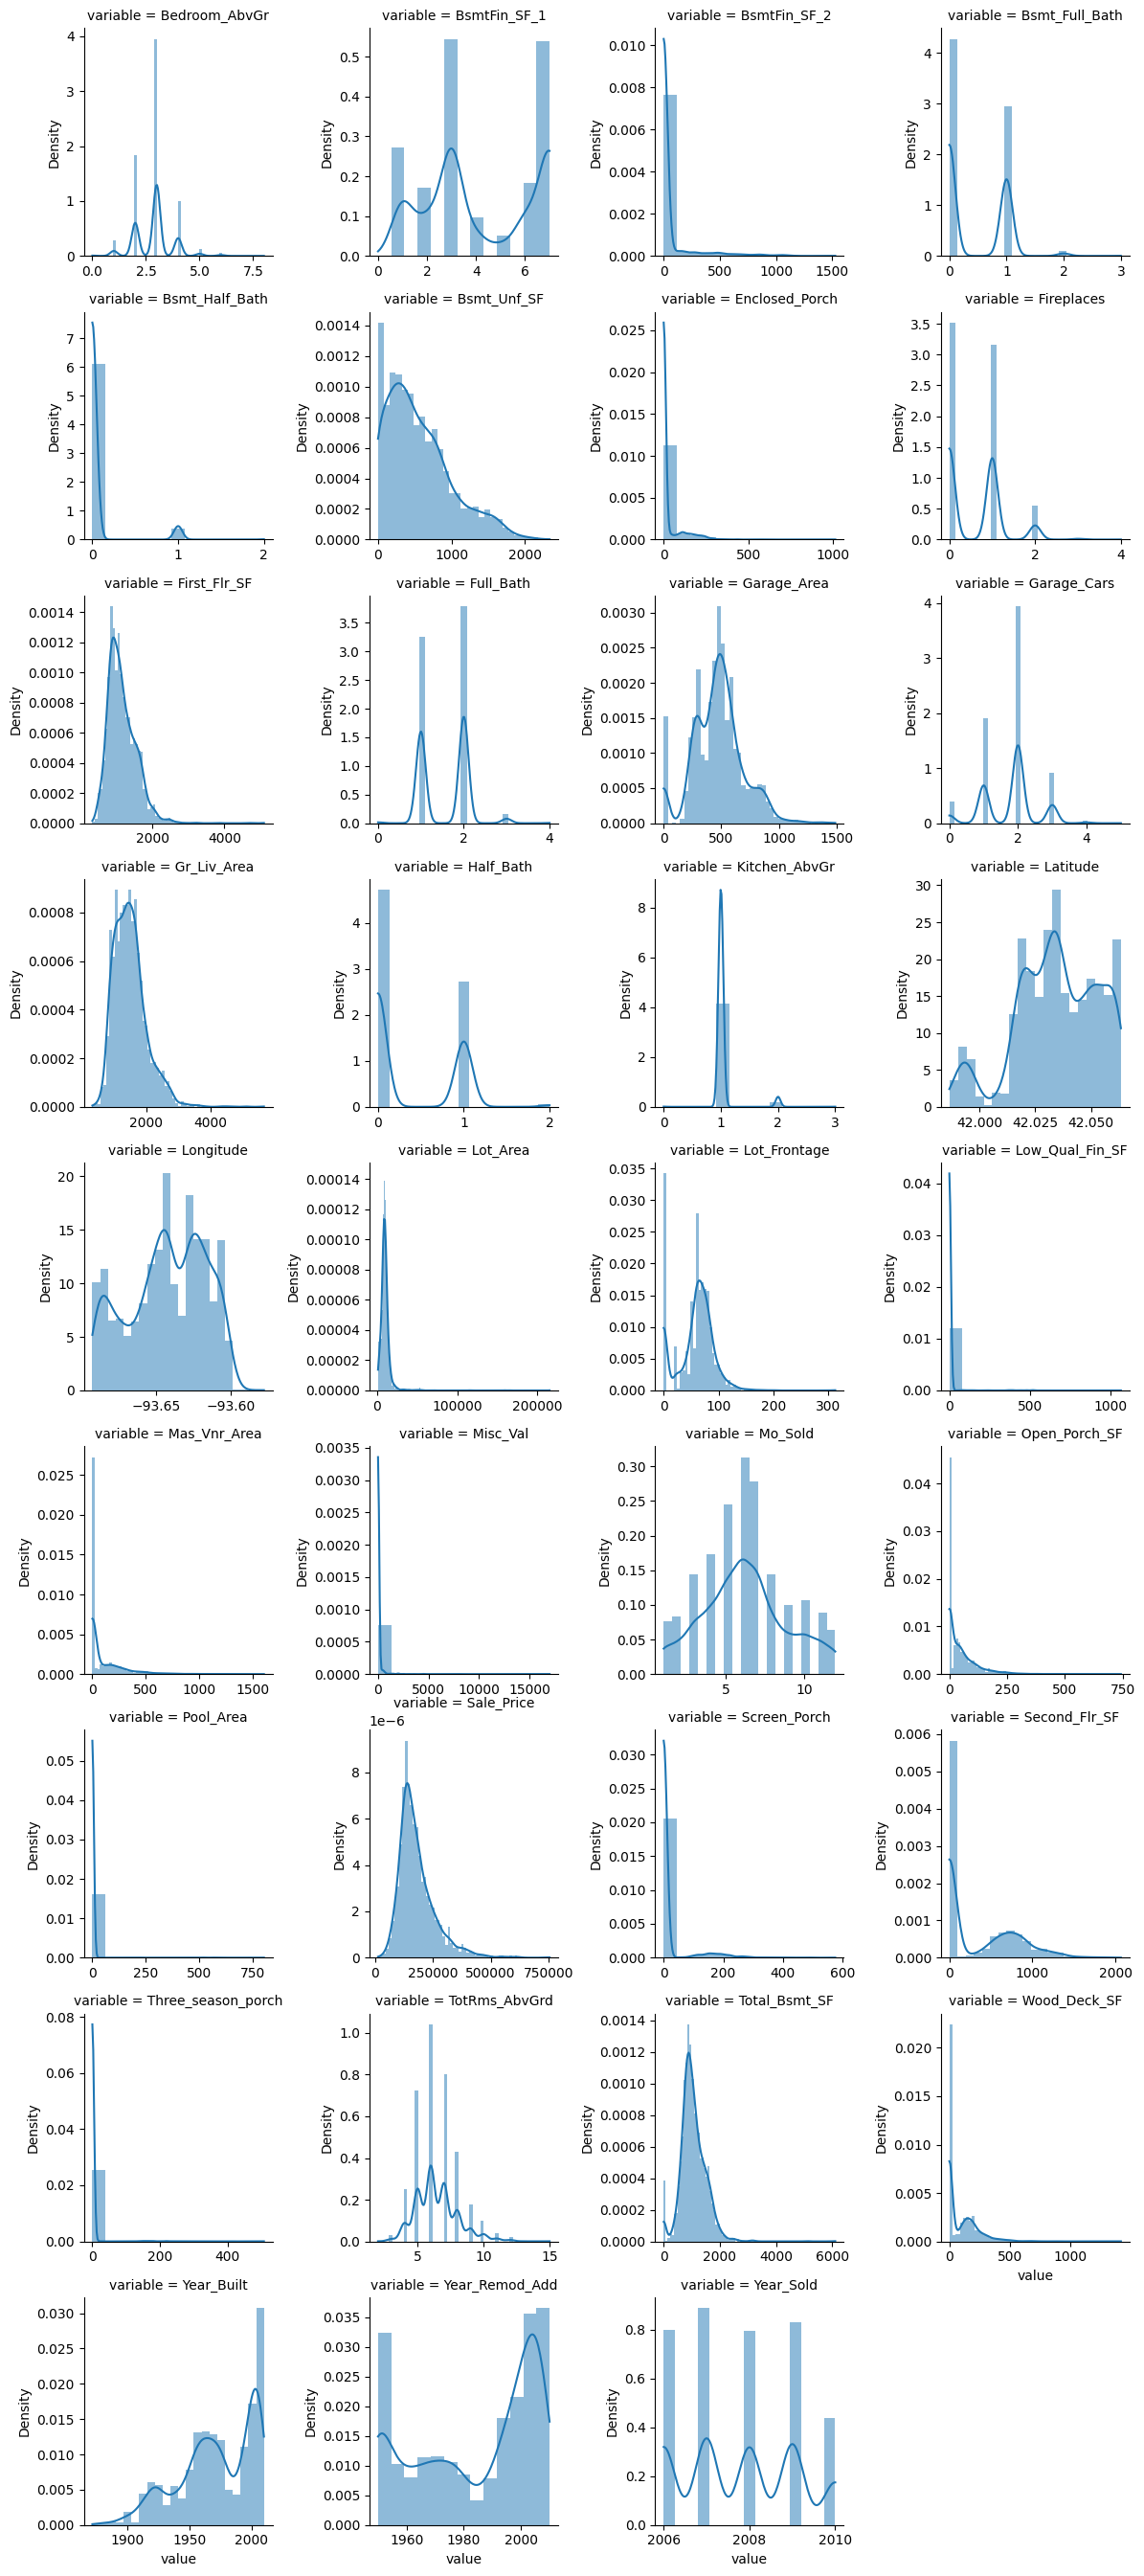

In [5]:
# Plottiamo la distribuzione delle features numeriche con un istogramma e la curva di densità
f = pd.melt(df, value_vars = sorted(num_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.histplot, 'value', kde = True, stat = "density", linewidth = 0)

Possiamo vedere come alcune features non siano propriamente continue ma, anzi, contano il numero di case con
una caratteristica di un set di caratteristiche: [Bsmt_Full_Bath, Bsmt_Half_Bath, Full_Bath, Half_Bath, Bedroom_AbvGr, Kitchen_AbvGr, TotRms_AbvGr, Fireplaces, Garage_Cars].

Ad altre, invece, conviene prestare particolare attenzione, ovvero quelle che hanno un collegamento con il
concetto di tempo: [Year_Built, Year_Remod_Add, Mo_Sold, Year_Sold].

Siccome il nostro è un task di regressione, dovremmo trattare Mo_Sold e Year_Sold come features categoriali in
quanto, per esempio, non ha proprio senso la differenza in valore tra un mese o l'altro (es: distanza euclidea)
se non per determinare quando una casa è stata venduta rispetto a un'altra.
Siccome, però, per le nostre funzioni di splitting per anno, la trasformazione da numeriche a categoriali dà non pochi problemi, abbiamo deciso di tenerle come features numeriche.

Per Year_Built, invece, possiamo tenerla continua perché ci può indicare la "vecchiaia" della casa.

Un'ulteriore osservazione può essere fatta sulla distribuzione di quelle features come 'Gr_Liv_Area' oppure 'First_Flr_SF' che sembrerebbero seguire una distribuzione normale!  

A questo proposito, dopo aver identificato le features continue proveremo a logaritmizzarle come abbiamo fatto con 'Sale_Price'.

## Valori a Zero

Abbiamo molte features con conteggi messi a zero, forse dovremmo darle un'occhiata.

<AxesSubplot: >

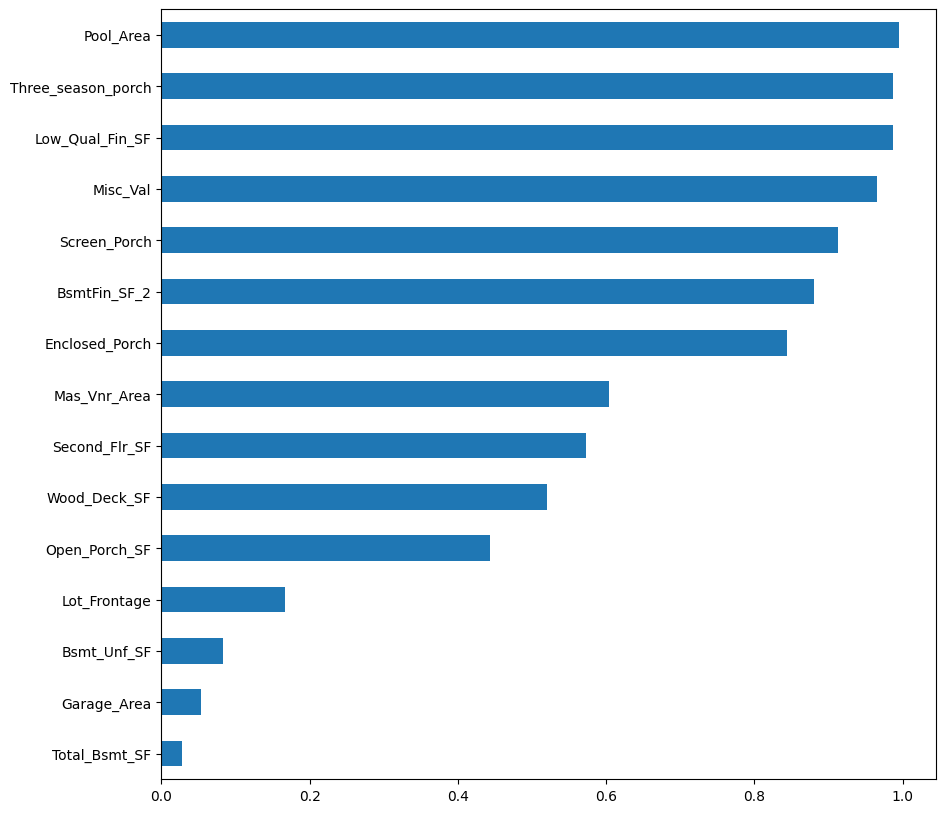

In [6]:
# Prendiamo le features che ritenevamo discrete
discrete_ftrs = ['Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr',
                  'TotRms_AbvGr', 'Fireplaces', 'Garage_Cars', 'BsmtFin_SF_1', 'Year_Sold', 'Mo_Sold']

# Prendiamo le features che riteniamo, invece, continue
non_discrete_ftrs = [f for f in num_features if f not in discrete_ftrs]

# Calcoliamo la percentuale di zeri di ogni feature
perc_zeroes = (df[non_discrete_ftrs] == 0).sum() / df.shape[0]

# Togliamo dalla lista quelle che non hanno zeri e le riordiniamo in ordine decrescente
# per facilitarne l'individualizzazione di quelle più interessanti
perc_zeroes = perc_zeroes[perc_zeroes > 0].sort_values(ascending = True)
perc_zeroes.plot(kind = 'barh', figsize = (10, 10))

Queste variabili sono spesso correlate con altre e quindi i loro valori sono influenzati da esse.  
Osservando 'Pool_Area', ha un'alta percentuali di zeri all'interno del dataset e per questo ci viene da pensare che tale variabile, che è sicuramente correlata con 'Pool_QC', abbia un'alta percentuale di zeri proprio perché 'Pool_QC' stessa ha un conteggio di case senza piscina molto alto.

Verifichiamo velocemente quanto ipotizzato:

No_Pool      2917
Excellent       4
Good            4
Typical         3
Fair            2
Name: Pool_QC, dtype: int64

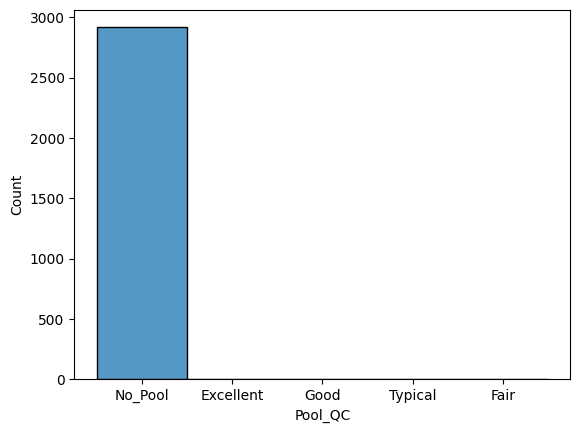

In [7]:
sns.histplot(data = df, x = 'Pool_QC', stat = 'count')

# Mostriamo anche i numeri del conteggio delle categorie per maggiore chiarezza
df['Pool_QC'].value_counts()

## Grafico delle relazioni con Sale Price e Outliers

Prima di trasformare le features numeriche, analizziamo la relazione di ciascuna feature con il target d'interesse, ovvero 'Sale_Price'.

Iniziamo col plottare ogni relazione e vediamo cosa possiamo trovare d'interessante:

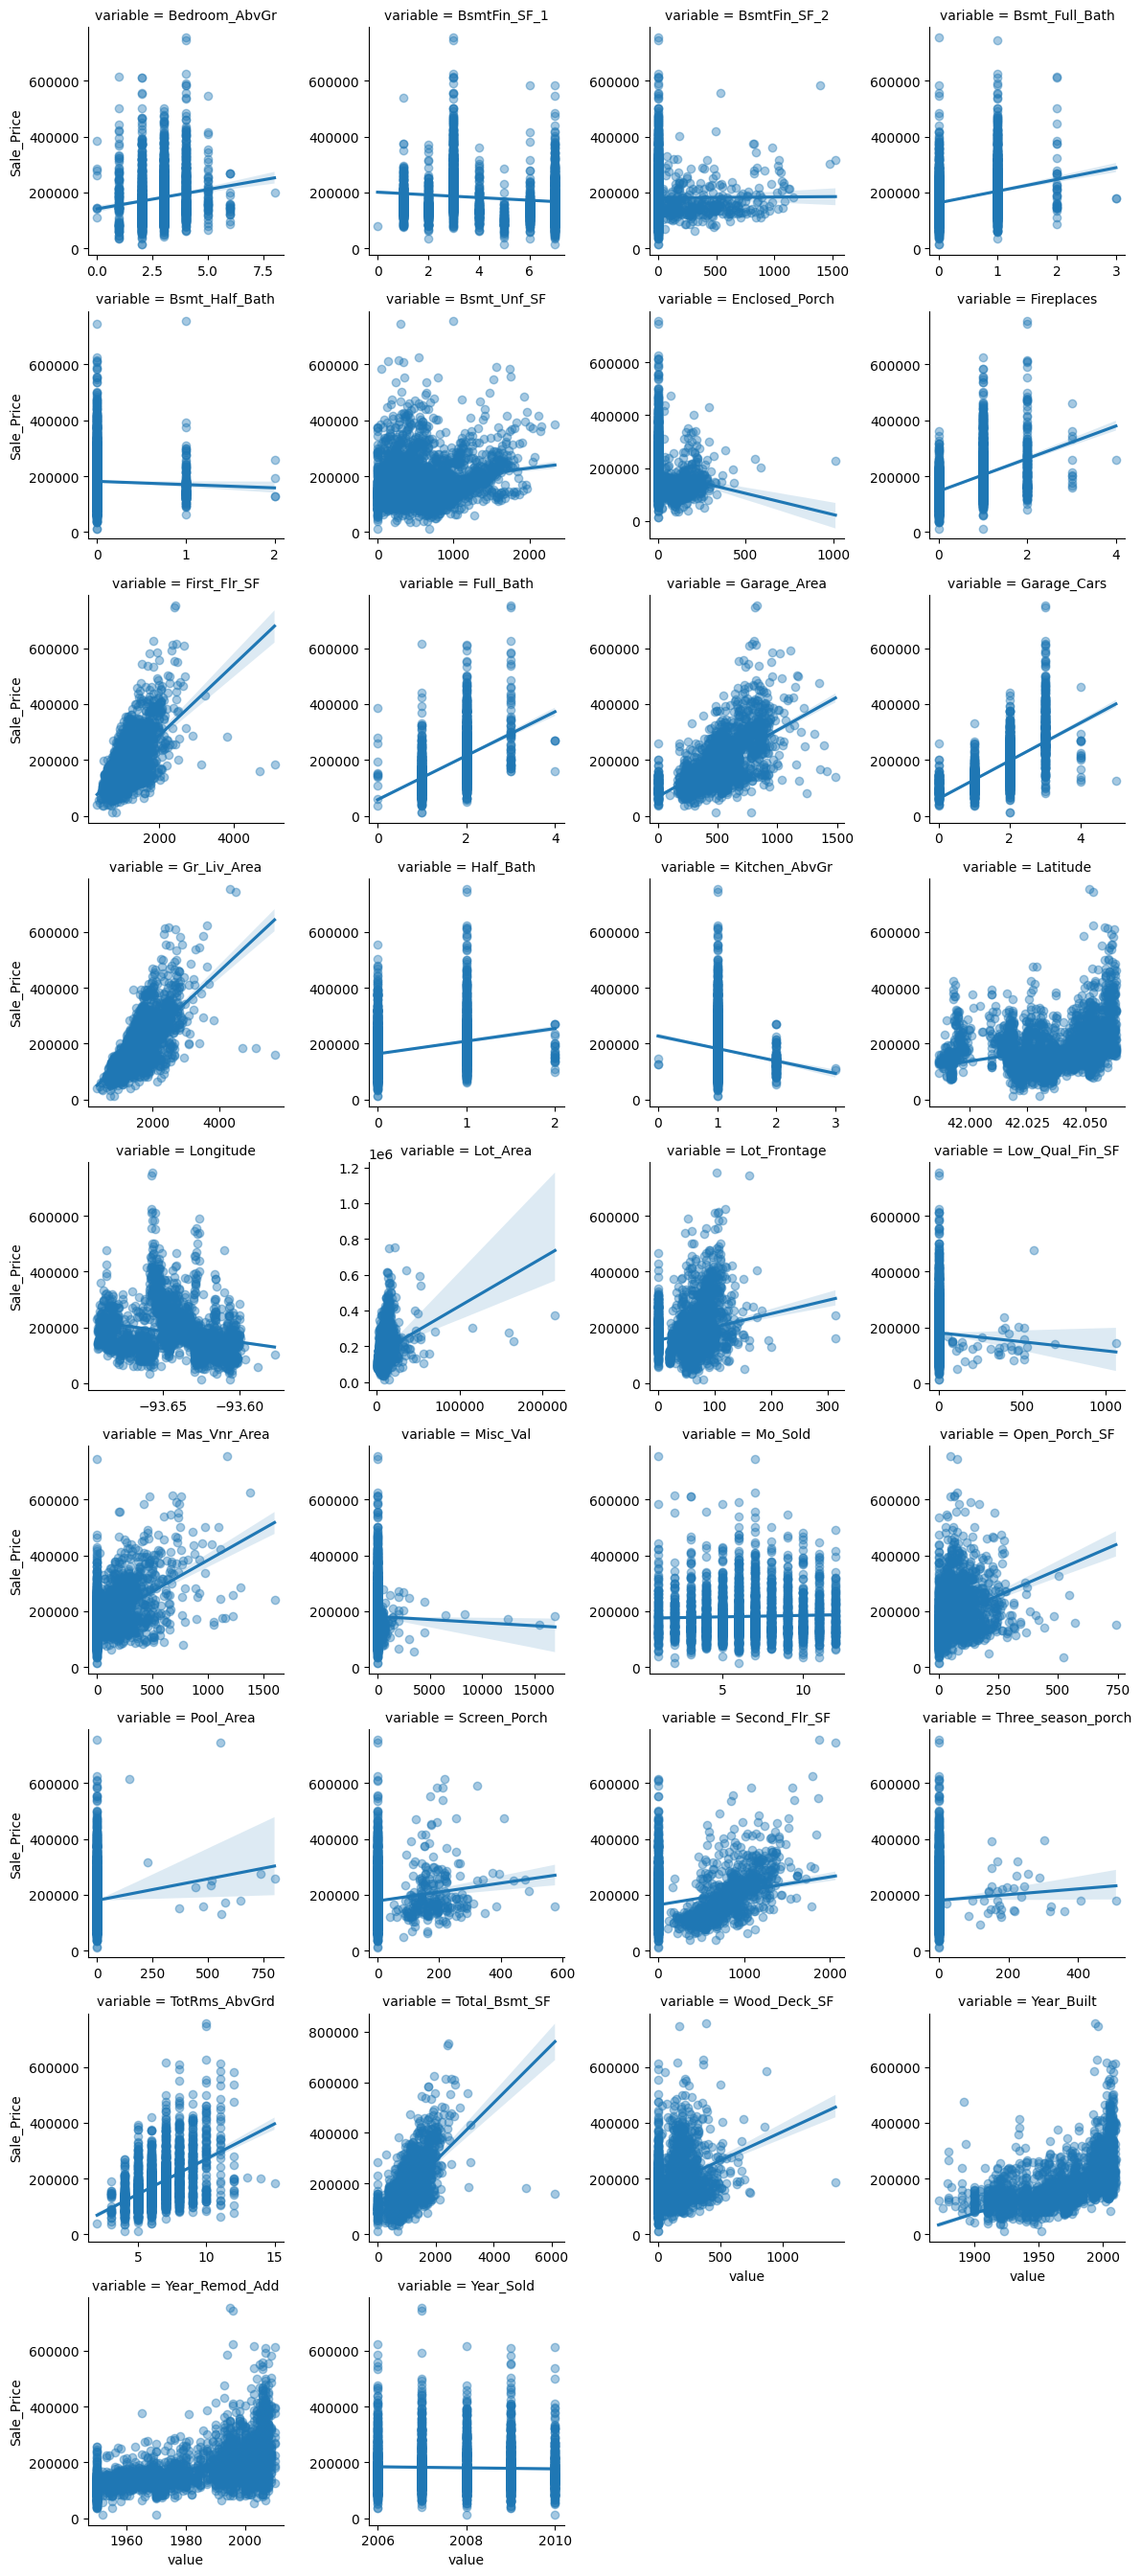

In [8]:
# Plottiamo tutte le features numeriche con un plot di regressione lineare insieme a un grafico a dispersione mostrando la relazione con 'Sale_Price'
f = pd.melt(df, id_vars = ['Sale_Price'], value_vars = sorted(num_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)

g = g.map(sns.regplot, 'value', 'Sale_Price', scatter = True, scatter_kws = {'alpha': 0.4})

g.fig.tight_layout()
plt.show()

Dai grafici si possono notare alcuni punti fastidiosi.  

Tra tutti questi grafici, scegliamo quello che mette in relazione 'Sale_Price' con la variabile 'Gr_Liv_Area': questa feature indica l'area vivibile della casa.
Generalmente, più una casa è grande più dovrebbe costare (senza contare altre variabili).

<AxesSubplot: xlabel='Gr_Liv_Area', ylabel='Sale_Price'>

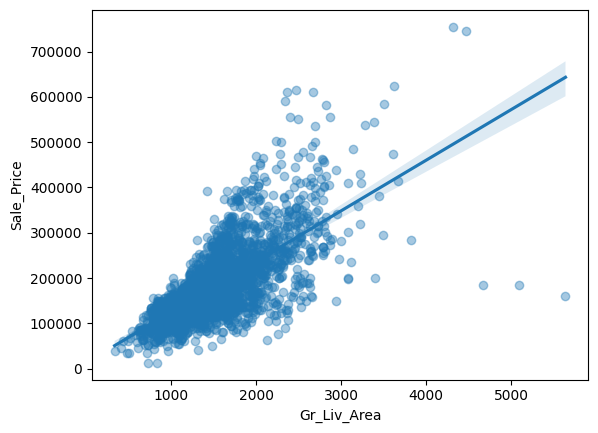

In [9]:
sns.regplot(x = df['Gr_Liv_Area'], y = df['Sale_Price'], scatter = True, scatter_kws = {'alpha': 0.4})

Si può notare che le case che hanno un'area vivibile maggiore di 4000 hanno un comportamento un po' particolare.

Proviamo a vedere le caratteristiche di questi dati:

In [10]:
df[(df['Gr_Liv_Area'] > 4000) & (df['Sale_Price'] < 200000)].sort_values(by = 'Sale_Price')

MS_SubClass                MS_Zoning  \
1498             Two_Story_1946_and_Newer  Residential_Low_Density   
2180  One_Story_1946_and_Newer_All_Styles  Residential_Low_Density   
2181             Two_Story_1946_and_Newer  Residential_Low_Density   

      Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
1498           313     63887   Pave  No_Alley_Access           Irregular   
2180           128     39290   Pave  No_Alley_Access  Slightly_Irregular   
2181           130     40094   Pave  No_Alley_Access  Slightly_Irregular   

     Land_Contour Utilities Lot_Config  ...     Fence Misc_Feature Misc_Val  \
1498          Bnk    AllPub     Corner  ...  No_Fence         None        0   
2180          Bnk    AllPub     Inside  ...  No_Fence         Elev    17000   
2181          Bnk    AllPub     Inside  ...  No_Fence         None        0   

     Mo_Sold Year_Sold Sale_Type Sale_Condition Sale_Price  Longitude  \
1498       1      2008       New        Partial     160000 -93.674898   
2180      10      2007       New        Partial     183850 -93.676220   
2181      10      2007       New        Partial     184750 -93.676241   

       Latitude  
1498  42.016804  
2180  42.016453  
2181  42.016642  

[3 rows x 81 columns]

Siccome sono outliers, rimuoviamoli dal dataset:

In [11]:
outliers = df[(df['Gr_Liv_Area'] > 4000) & (df['Sale_Price'] < 200000)].index

df.drop(outliers, inplace = True)

<AxesSubplot: xlabel='Gr_Liv_Area', ylabel='Sale_Price'>

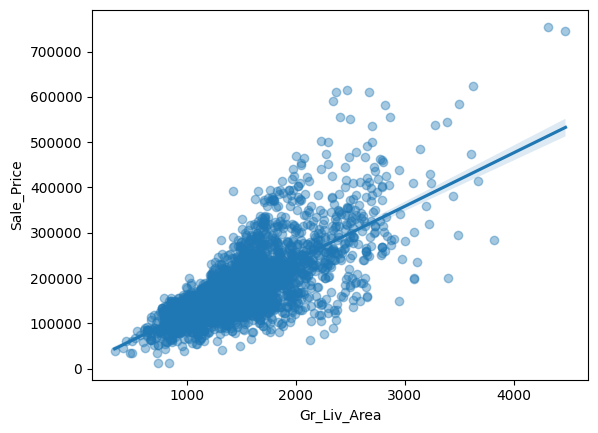

In [12]:
sns.regplot(x = df['Gr_Liv_Area'], y = df['Sale_Price'], scatter = True, scatter_kws = {'alpha': 0.4})

# Analisi della variabile target: Sale Price

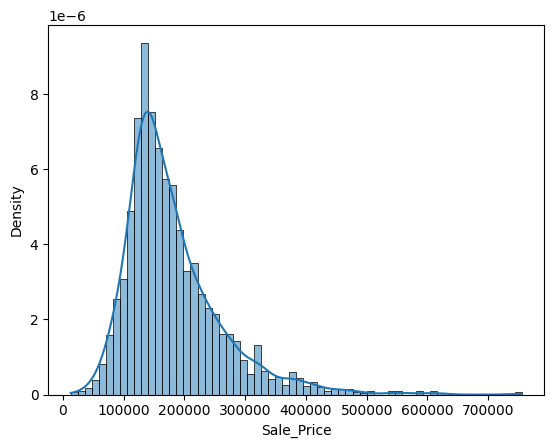

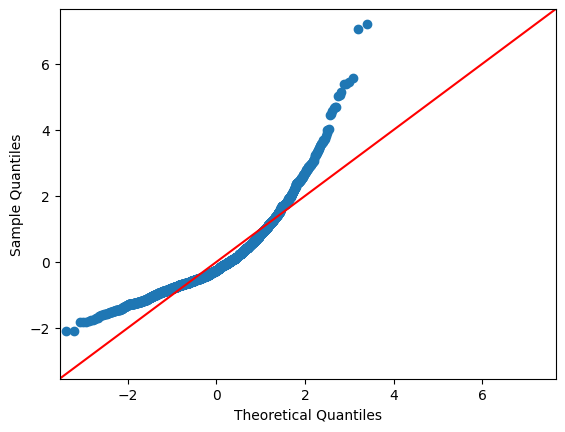

In [13]:
# Plottiamo la distribuzione della feature target tramite un istogramma e la curva di densità
sns.histplot(data = df, x = 'Sale_Price', kde = True, stat = 'density')
# Plottiamo anche il grafico dei quantili
qqplot(data = df['Sale_Price'], dist = norm, fit = True, line = "45")
plt.show()

Sembrerebbe assumere una distribuzione normale ma non è simmetrica e centrale come una "normale" distribuzione normale bensì è spostata più a sinistra.  

Proviamo a vedere se logaritmizzarla può sistemarla:

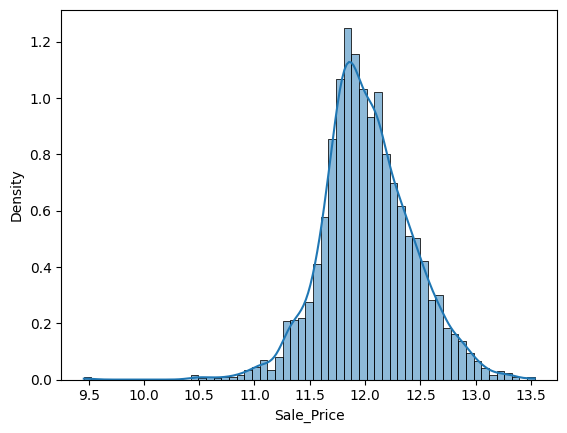

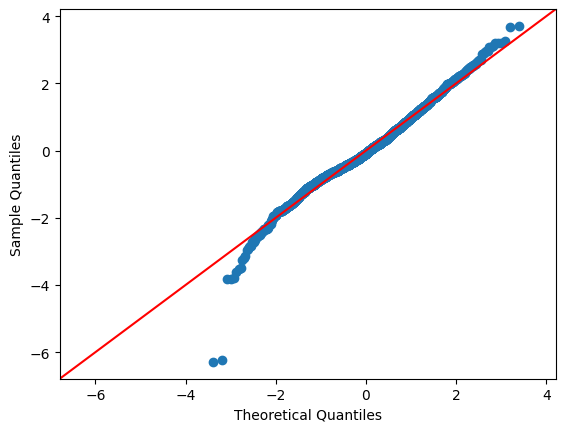

In [14]:
# Applichiamo la funzione logaritmo e sostituiamo la colonna originale
df.loc[:, 'Sale_Price'] = np.log(1 + df.loc[:, 'Sale_Price'])

#Ripetiamo i grafici
sns.histplot(data = df, x = 'Sale_Price', kde = True, stat = 'density')
qqplot(data = df['Sale_Price'], dist = norm, fit = True, line = "45")
plt.show()

Dal grafico dei quantili si può vedere come sia stata sistemata in generale.  
L'unico problema è la coda inferiore che non ci piace troppo.  



## Analisi della correlazione

Plottiamo anche la matrice di correlazione usando il metodo di Spearman: preferiamo il coefficiente di Spearman rispetto a quello di Pearson in quanto Spearman valuta la relazione monotonica tra due variabili mentre Pearson valuta la relazione lineare tra le due variabili.

**NOTA**: È stato provato anche il coefficiente di Pearson ma i valori cambiavano di pochissimo, dunque non è stato messo per alleggerire la lettura delle matrici e, in generale, del notebook.

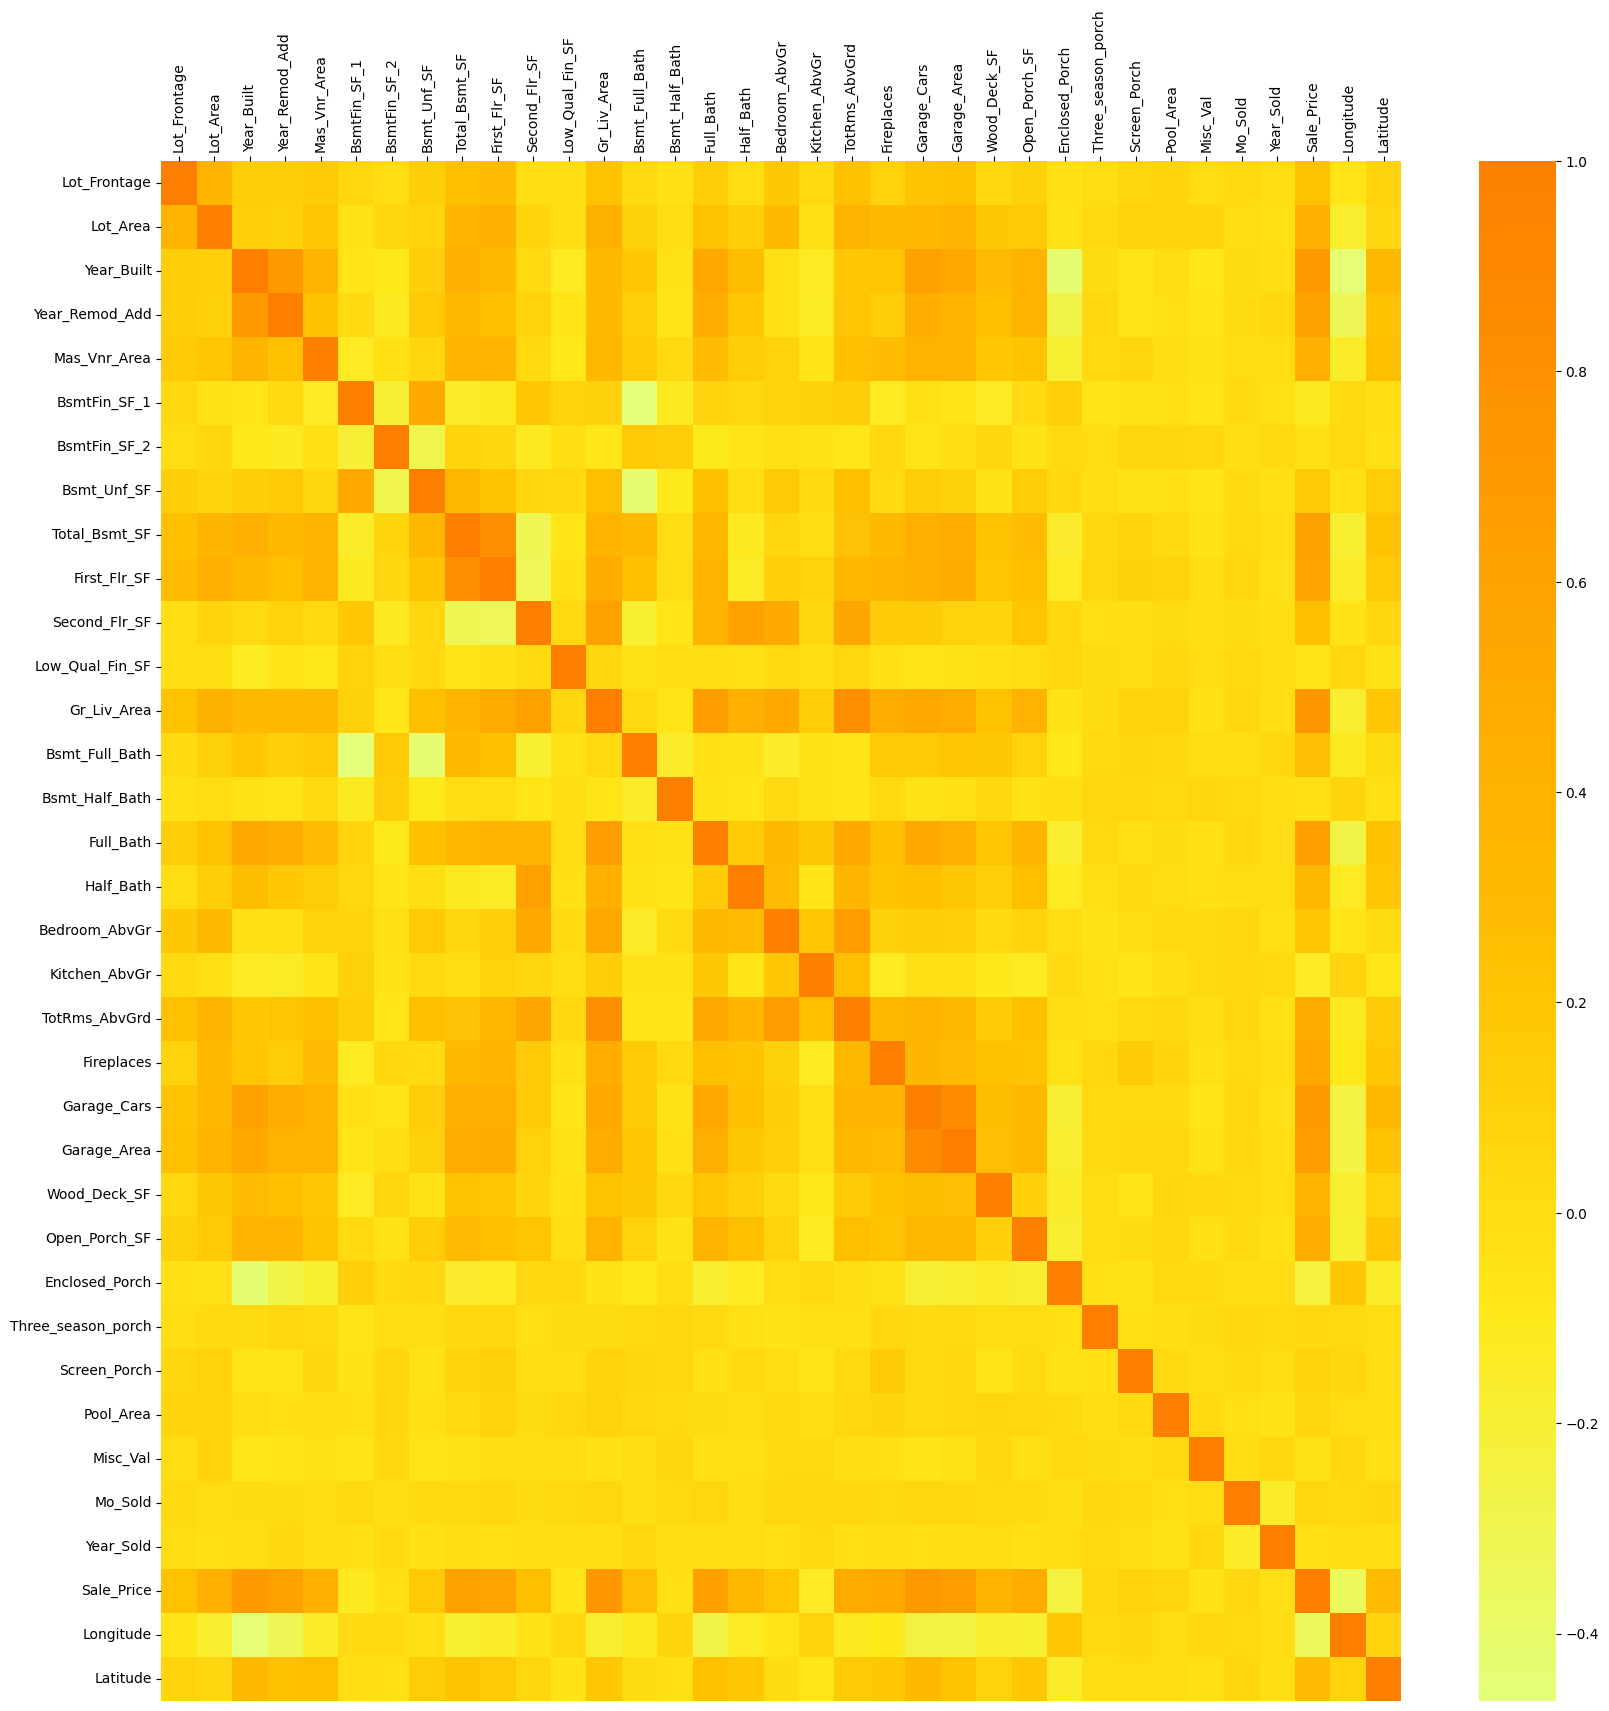

In [15]:
# Calcoliamo la matrice di correlazione tra tutte le features numeriche
corr_matrix = df[num_features].corr(method = 'spearman')

fig = plt.figure(figsize = (20, 20))

# Creo la heatmap
ax = fig.add_subplot(111)
sns.heatmap(corr_matrix, cmap = "Wistia", ax = ax)

# Sistemo le labels sopra la matrice per semplicità
ax.xaxis.tick_top()

# Le ruoto di 90° così non si sovrappongono
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.show()

Da questa matrice di correlazione non si capisce molto e stampare anche i valori all'interno delle celle renderebbe ancor più illegibile il grafico.

Siccome ci interessano solo alcune features, ovvero quelle che hanno una forte correlazione con 'Sale_Price', restringiamo il campo a quelle che hanno un coefficiente di correlazione maggiore di 0.5 con, appunto, 'Sale_Price'.

**NOTA**: Siccome viene presa una lista di features e non più un oggetto DataFrame, ci servono delle funzioni per plottare una matrice di correlazione per una lista. Queste funzioni sono state inserite nel file "heatmap.py" e sono state prese dal sito di matplotlib, più precisamente da qui: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html.

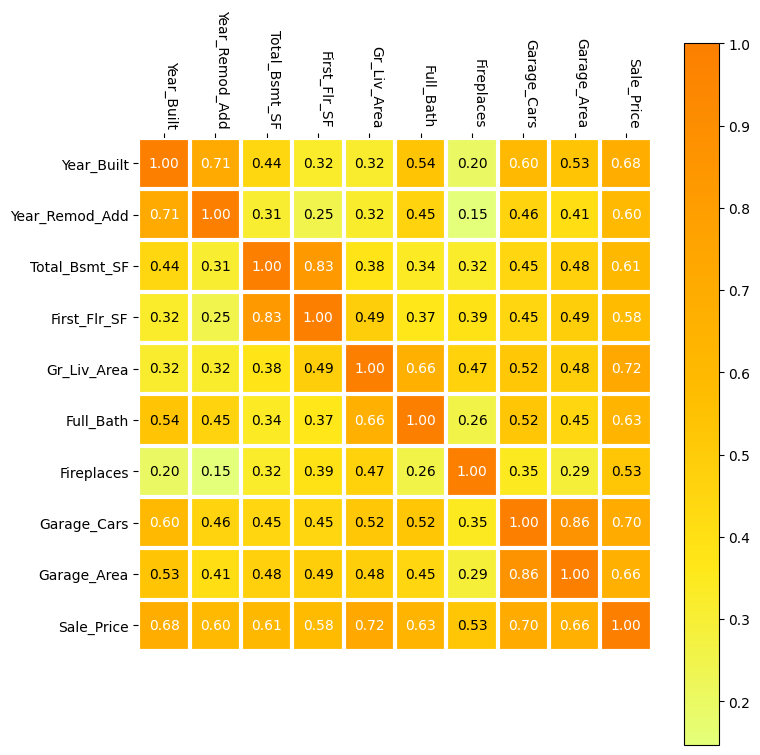

In [16]:
# Prendiamo una lista delle features che hanno un'alta correlazione
# con 'Sale_Price' per poi plottarle
highest_corrs = corr_matrix.index[ abs(corr_matrix['Sale_Price']) > 0.5 ]

## PLOTTING DELLE FEATURES
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = htmap.heatmap(df[highest_corrs].corr(method = 'spearman'), highest_corrs,
                         highest_corrs, ax = ax, cmap = "Wistia")

# Inseriamo anche i valori all'interno delle celle per maggiore chiarezza
texts = htmap.annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

## Trasformiamo alcune features categoriche

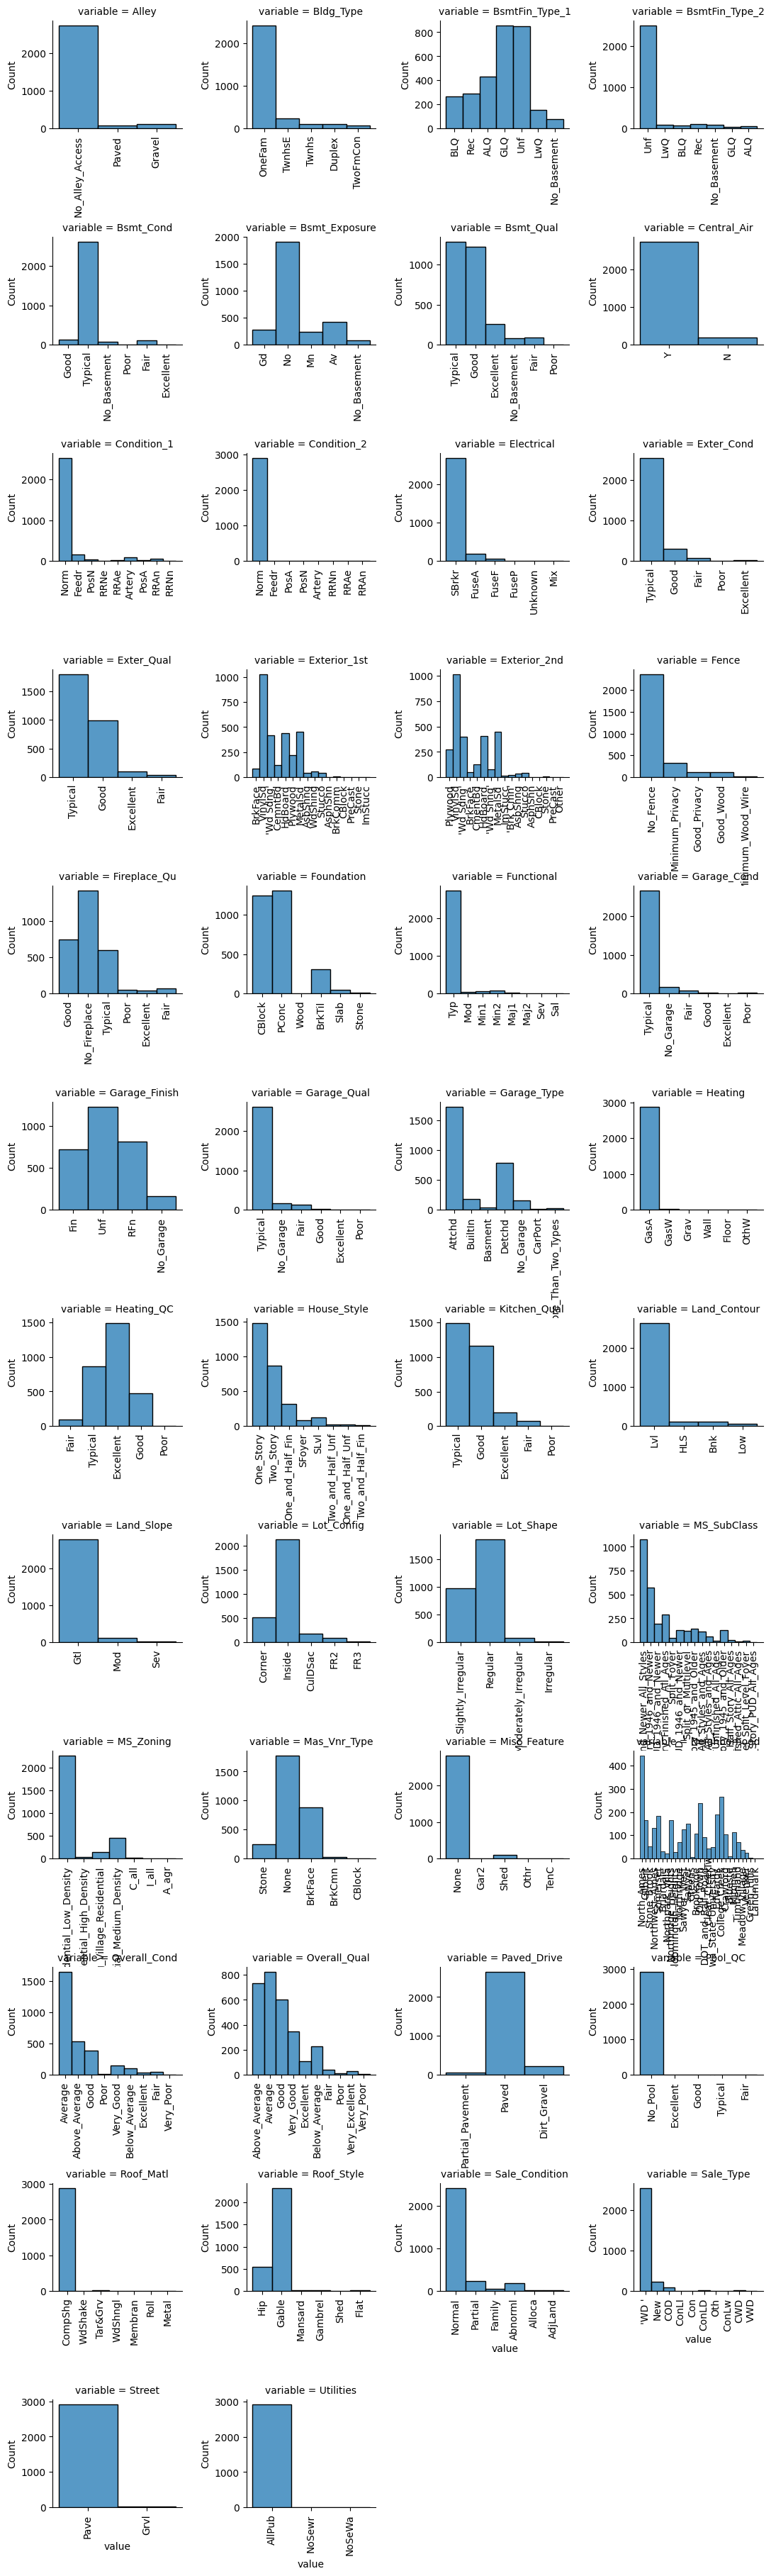

In [17]:
# Visualizziamo il conteggio dei valori di ogni variabile categorica tramite istogramma
f = pd.melt(df, value_vars = sorted(cat_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)

g = g.map(sns.histplot, 'value')

# Rotiamo le etichette dell'asse X per una maggiore chiarezza (anche se non cambia granché)
[plt.setp(ax.get_xticklabels(), rotation = 90) for ax in g.axes.flat]

plt.subplots_adjust(hspace = 1.0, wspace = 0.5)
plt.show()

In [18]:
# Per chiarezza mostriamo anche numericamente i conteggi delle features visto che i grafici
# non sono proprio chiari
for f in sorted(cat_features):
    print(f"\tFEATURE: {f}")
    print(df[f].value_counts(), '\n\n')

	FEATURE: Alley
No_Alley_Access    2729
Gravel              120
Paved                78
Name: Alley, dtype: int64 


	FEATURE: Bldg_Type
OneFam      2422
TwnhsE       233
Duplex       109
Twnhs        101
TwoFmCon      62
Name: Bldg_Type, dtype: int64 


	FEATURE: BsmtFin_Type_1
GLQ            856
Unf            851
ALQ            429
Rec            288
BLQ            269
LwQ            154
No_Basement     80
Name: BsmtFin_Type_1, dtype: int64 


	FEATURE: BsmtFin_Type_2
Unf            2496
Rec             106
LwQ              89
No_Basement      81
BLQ              68
ALQ              53
GLQ              34
Name: BsmtFin_Type_2, dtype: int64 


	FEATURE: Bsmt_Cond
Typical        2613
Good            122
Fair            104
No_Basement      80
Poor              5
Excellent         3
Name: Bsmt_Cond, dtype: int64 


	FEATURE: Bsmt_Exposure
No             1906
Av              418
Gd              281
Mn              239
No_Basement      83
Name: Bsmt_Exposure, dtype: int64 


	FEATURE: Bs

Dai grafici (e dai conteggi del blocco successivo al grafico) è possibile osservare due particolari:
> Molte variabili categoriche tendono ad avere dei valori predominanti (es: 'Street' ha *Pave* che "domina" su *Grvl*);

> Alcune delle variabili categoriche possono essere discretizzate numericamente per facilitarne la comprensione ai vari modelli (es: 'Exter_Qual' ha i valori ['Typical', 'Good', 'Excellent', 'Fair'] che possono essere discretizzati numericamente.

Quindi dobbiamo ridiscretizzare tutte quelle che hanno la seconda caratteristica.  
Per le features che cadono anche nel primo caso bisogna decidere opportunamente come proseguire per eliminare quei pochi valori presenti senza inefficiare le predizioni dei modelli o, addirittura, rompere il dataset!  

Guardano, una per una, tutte le variabili categoriche e i valori che assumono, si giunge alla conclusione che le seguenti features debbano essere trasformate in numeriche in quanto possiedono una relazione d'ordine (variabili ordinali):

In [19]:
#Modifichiamo le colonne del dataframe rimappando le variabili categoriali in numeriche

# Lot Shape
df.Lot_Shape.replace({'Regular': 4, 'Slightly_Irregular': 3,
                      'Moderately_Irregular': 2, 'Irregular': 1}, inplace = True)

# Utilities
df.Utilities.replace({'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}, inplace = True)

# Land Slope
df.Land_Slope.replace({'Sev': 1, 'Mod': 2, 'Gtl': 3}, inplace = True)

# Exterior Quality
df.Exter_Qual.replace({'Fair': 1, 'Typical': 2, 'Good': 3, 'Excellent': 4}, inplace = True)

# Exterior Condition
df.Exter_Cond.replace({'Poor': 1, 'Fair': 2, 'Typical': 3, 'Good': 4, 'Excellent': 5}, inplace = True)

# Basement Quality
df.Bsmt_Qual.replace({'No_Basement': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3,
                      'Good': 4, 'Excellent': 5}, inplace = True)

# Basement Condition
df.Bsmt_Cond.replace({'No_Basement': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3, 'Good': 4, 'Excellent': 5}, inplace = True)

# Basement Exposure
df.Bsmt_Exposure.replace({'No_Basement': 0, 'No': 1, 'Mn': 2, 'Av':3, 'Gd':4}, inplace = True)

# Finished Basement 1 Rating
df.BsmtFin_Type_1.replace({'No_Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}, inplace = True)

# Finished Basement 2 Rating
df.BsmtFin_Type_2.replace({'No_Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}, inplace=True)

# Heating Quality and Condition
df.Heating_QC.replace({'Poor': 1, 'Fair': 2, 'Typical': 3, 'Good': 4, 'Excellent': 5}, inplace=True)

# Kitchen Quality
df.Kitchen_Qual.replace({'Poor': 1, 'Fair': 2, 'Typical': 3, 'Good': 4, 'Excellent': 5}, inplace=True)

# Home functionality
df.Functional.replace({'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6,
                       'Min1': 7, 'Typ': 8}, inplace = True)

# Fireplace Quality
df.Fireplace_Qu.replace({'No_Fireplace': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3,
                         'Good': 4, 'Excellent': 5}, inplace = True)

# Garage Finish
df.Garage_Finish.replace({'No_Garage': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}, inplace = True)

# Garage Quality
df.Garage_Qual.replace({'No_Garage': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3,
                         'Good': 4, 'Excellent': 5}, inplace = True)

# Garage Condition
df.Garage_Cond.replace({'No_Garage': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3,
                         'Good': 4, 'Excellent': 5}, inplace = True)

# Paved Driveway
df.Paved_Drive.replace({'Dirt_Gravel': 1, 'Partial_Pavement': 2, 'Paved': 3}, inplace = True)

# Pool Quality
df.Pool_QC.replace({'No_Pool': 0, 'Poor': 1, 'Fair': 2, 'Typical': 3,
                    'Good': 4, 'Excellent': 5}, inplace=True)

# Overall_Qual
df.Overall_Qual.replace({'Very_Poor': 1, 'Poor': 2, 'Fair': 3, 'Below_Average': 4, 'Average': 5, 'Above_Average': 6,
                        'Good': 7, 'Very_Good': 8, 'Excellent': 9, 'Very_Excellent': 10}, inplace = True)

# Overall_Cond
df.Overall_Cond.replace({'Very_Poor': 1, 'Poor': 2, 'Fair': 3, 'Below_Average': 4, 'Average': 5, 'Above_Average': 6,
                        'Good': 7, 'Very_Good': 8, 'Excellent': 9, 'Very_Excellent': 10}, inplace = True)

# Fence
df.Fence.replace({'No_Fence': 0, 'Minimum_Wood_Wire': 1, 'Good_Wood': 2, 'Minimum_Privacy': 3, 'Good_Privacy': 4}, inplace = True)

Ora che sono queste features sono state trasformate in numeriche (ordinali), aggiorniamo la lista delle variabili categoriche e numeriche e proviamo a ridisegnare la *heatmap* della matrice di correlazione delle variabili numeriche che sono maggiormente correlate con 'Sale_Price':

In [20]:
# Aggiorniamo le variabili numeriche e categoriche
num_features, cat_features = features.get_feature_groups(df)

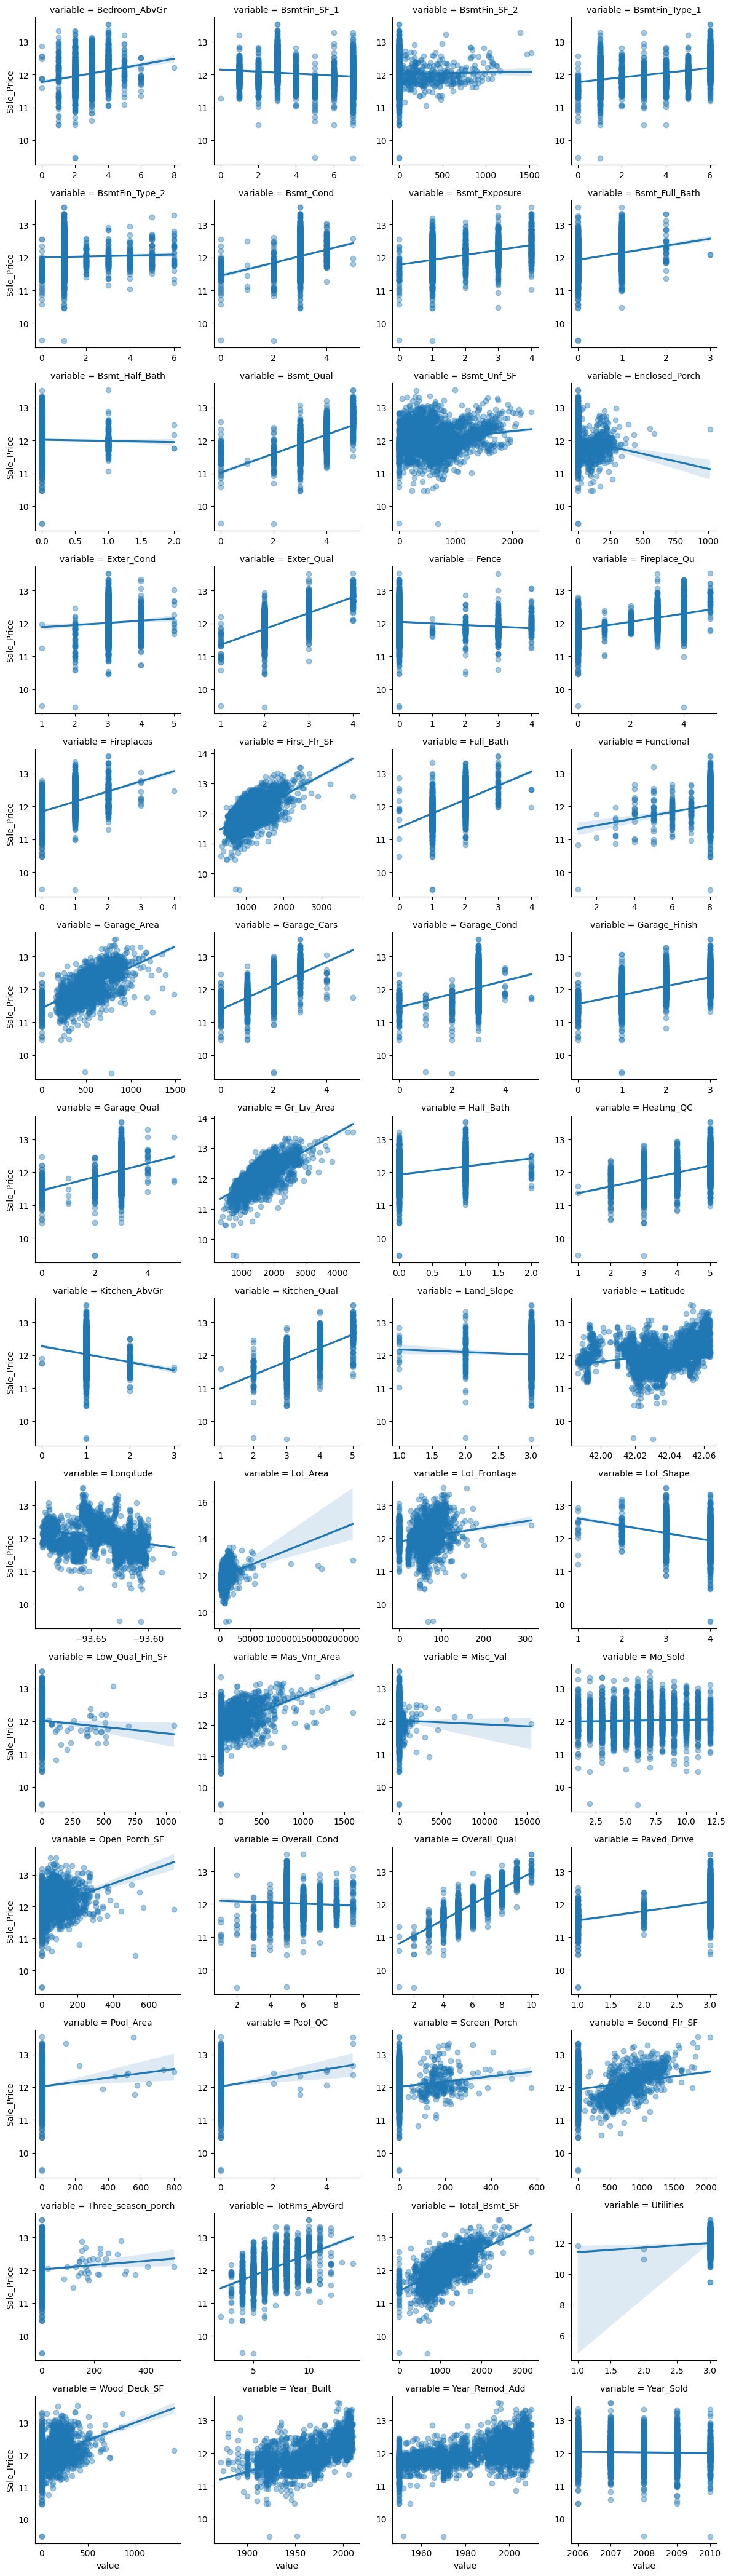

In [21]:
# Plottiamo tutte le features numeriche con un un plot di regressione lineare insieme a un grafico a dispersione mostrando la relazione con 'Sale_Price'
f = pd.melt(df, id_vars = ['Sale_Price'], value_vars = sorted(num_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)

g = g.map(sns.regplot, 'value', 'Sale_Price', scatter = True, scatter_kws = {'alpha': 0.4})

g.fig.tight_layout()
plt.show()

Tra la ventina di features che sono state aggiunte alle variabili numeriche, possiamo vedere come alcune di esse [Garage_Finish, Fireplace_Qu, Exter_Qual, Kitchen_Qual, Overall_Qual] siano ben correlate con la nostra variabile da predire.  

Proviamo ad aggiungere qualche altra feature sulla base di quelle standard e vediamo se ci possono dare più informazioni per il nostro task di regressione:

## Aggiunta di nuove features

Dopo aver analizzato le features già esistenti nel dataset, proviamo a inserirne di nuove per vedere se possono aiutarci con il nostro task di predizione.

Partiamo con l'aggiungere delle features che danno delle informazioni più generiche sull'abitazione:

In [22]:
### Features Aggiunte con alta correlazione


# Total Square Feet (Sia sopra al terreno abitabile (1 e 2 piano) che sotto al terreno (seminterrato))
df['Total_SF'] = df['Gr_Liv_Area'] + df['Total_Bsmt_SF']

# Total Bathrooms
df['Total_Baths'] = df['Full_Bath'] + df['Bsmt_Full_Bath'] + df['Half_Bath'] * 0.5 + df['Bsmt_Half_Bath'] * 0.5

# Età della casa (NOTA: C'è un caso particolare in cui la casa è stata venduta prima della sua costruzione)
df['House_Age'] = df['Year_Sold'].astype(int) - df['Year_Built']
df['House_Age'] = df['House_Age'].apply(lambda x : x if x >= 0 else 0)



### Features Aggiunte ma con bassa correlazione


# Total Porch Square Feet
df['Total_Porch_SF'] = df['Open_Porch_SF'] + df['Enclosed_Porch'] + df['Three_season_porch'] + df['Screen_Porch']



### Altre Features Aggiunte (Booleane)


# Is New (Assumiamo che le case costruite entro il decennio dell'anno più recente del dataset (2010) siano nuove)
df['Is_New'] = (df['Year_Built'] >= 2000).astype(int)

# Is Remodded
df['Is_Remodded'] = (df['Year_Remod_Add'] != df['Year_Built']).astype(int)

Dopo aver aggiunte le features al dataframe, aggiorniamo il Train Set e Test Set e plottiamo nuovamente la matrice di correlazione per vedere come vanno queste nuove features inserite:

In [23]:
# Aggiorniamo le variabili numeriche e categoriche
num_features, cat_features = features.get_feature_groups(df)

E plottiamo anche la matrice di correlazione:

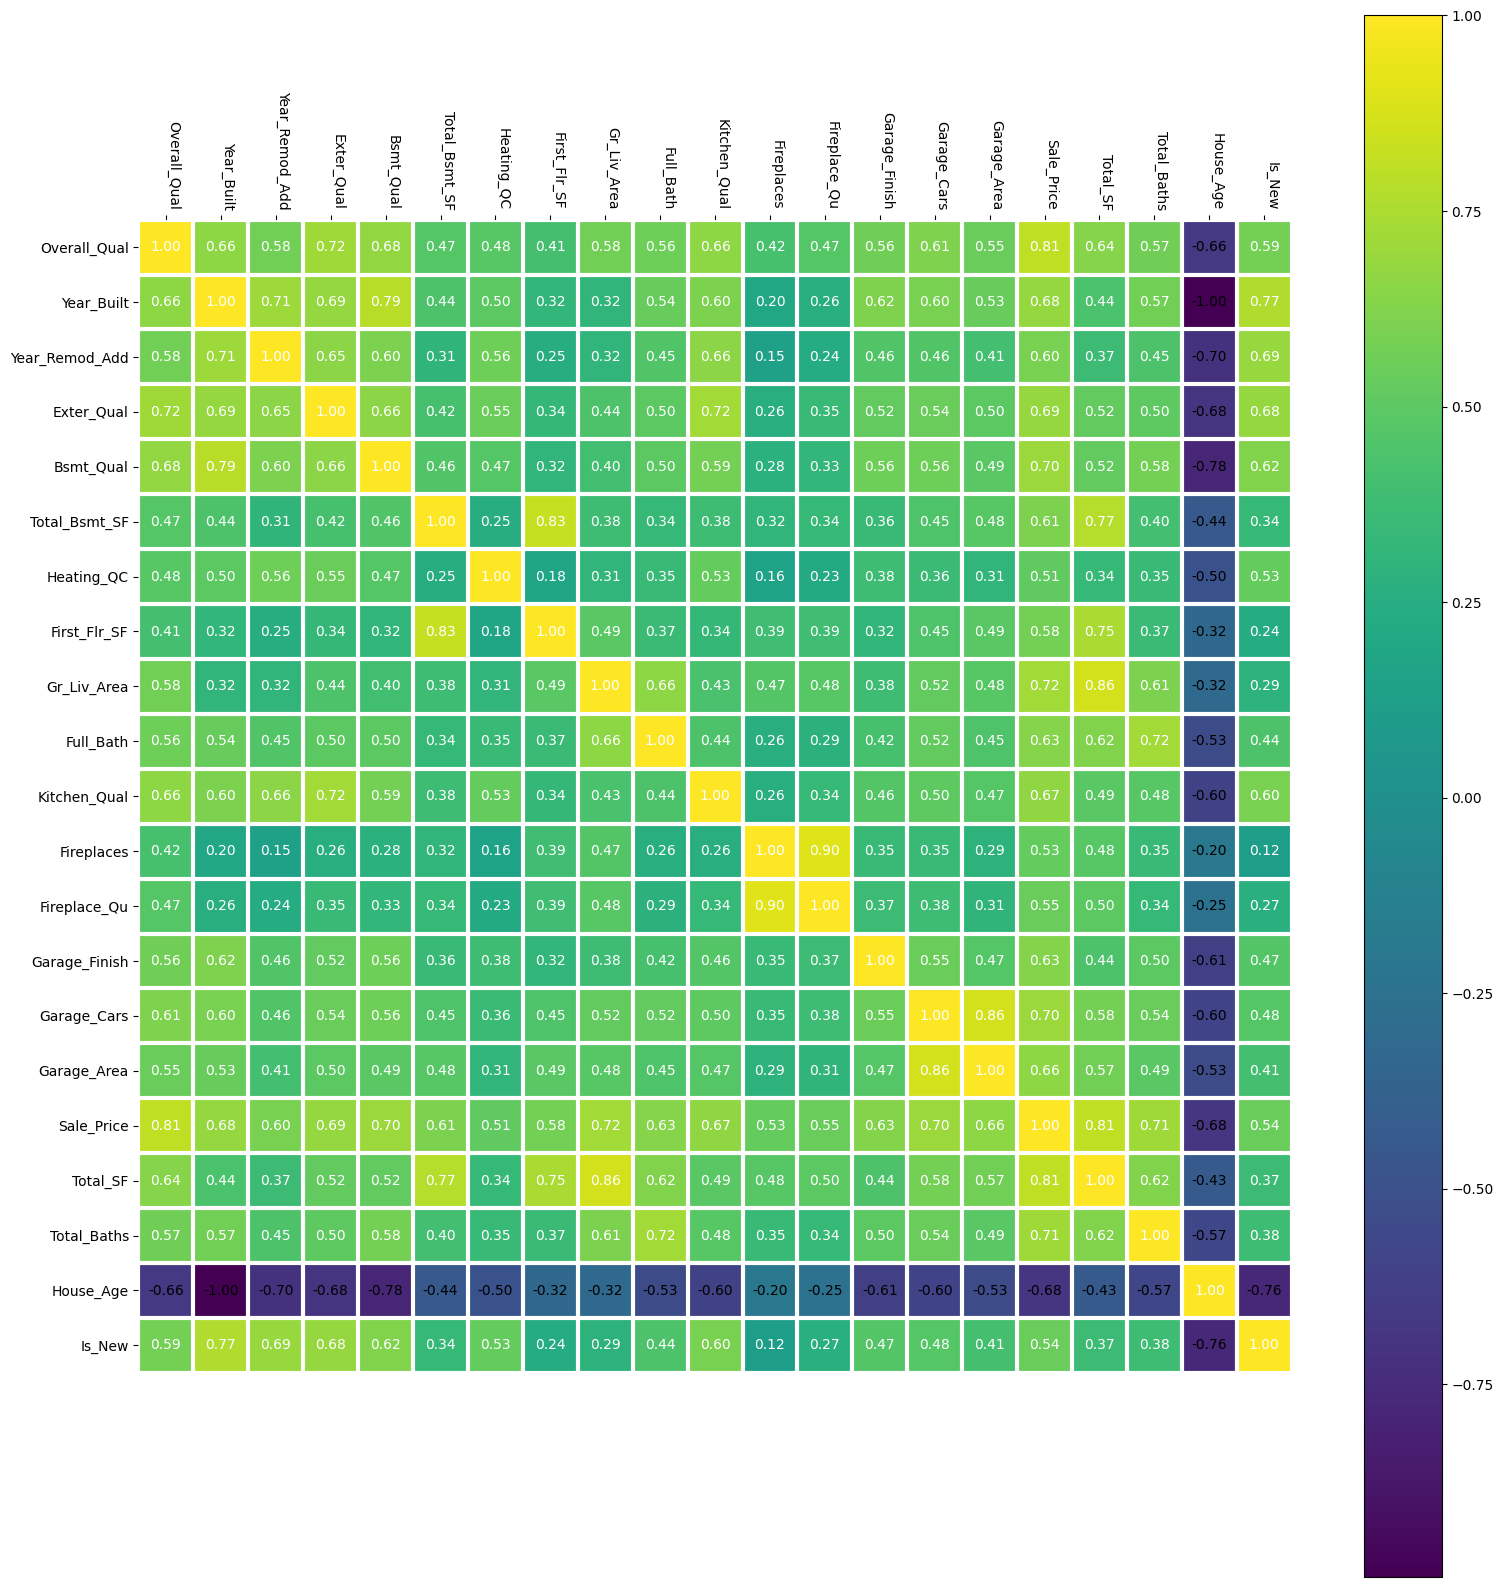

In [24]:
# Calcoliamo la matrice di correlazione tra tutte le features numeriche (comprese quelle aggiunte)
corr_matrix = df[num_features].corr(method = 'spearman')

# Prendiamo una lista delle features che hanno un'alta correlazione
# con 'Sale_Price' per poi plottarle
highest_corrs = corr_matrix.index[ abs(corr_matrix['Sale_Price']) > 0.5 ]

## PLOTTING DELLE FEATURES (16, 16)
fig, ax = plt.subplots(figsize = (16, 16))

# Cambiamo scala dei colori per in quanto la colorazione calda non faceva tanta distinzione tra i valori
im, cbar = htmap.heatmap(df[highest_corrs].corr(method = 'spearman'), highest_corrs,
                         highest_corrs, ax = ax)

# Inseriamo anche i valori all'interno delle celle per maggiore chiarezza
texts = htmap.annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

Ora che abbiamo tutte le features numeriche interessanti, possiamo scegliere quelle che ci servono valutando anche la correlazione che hanno con le altre variabili.  

Si è tenuto conto della correlazione con 'Sale_Price' ma anche con le altre variabili.  

Un esempio è 'Total_SF': è altamente correlata con 'Tot_Bsmt_SF', 'First_Flr_SF' e 'Gr_Liv_Area', ma è altrettanto altamente correlata con 'Sale_Price' (82%), quindi si è deciso di tenere 'Total_SF' e buttare le altre.

## Normalizzazione delle features numeriche

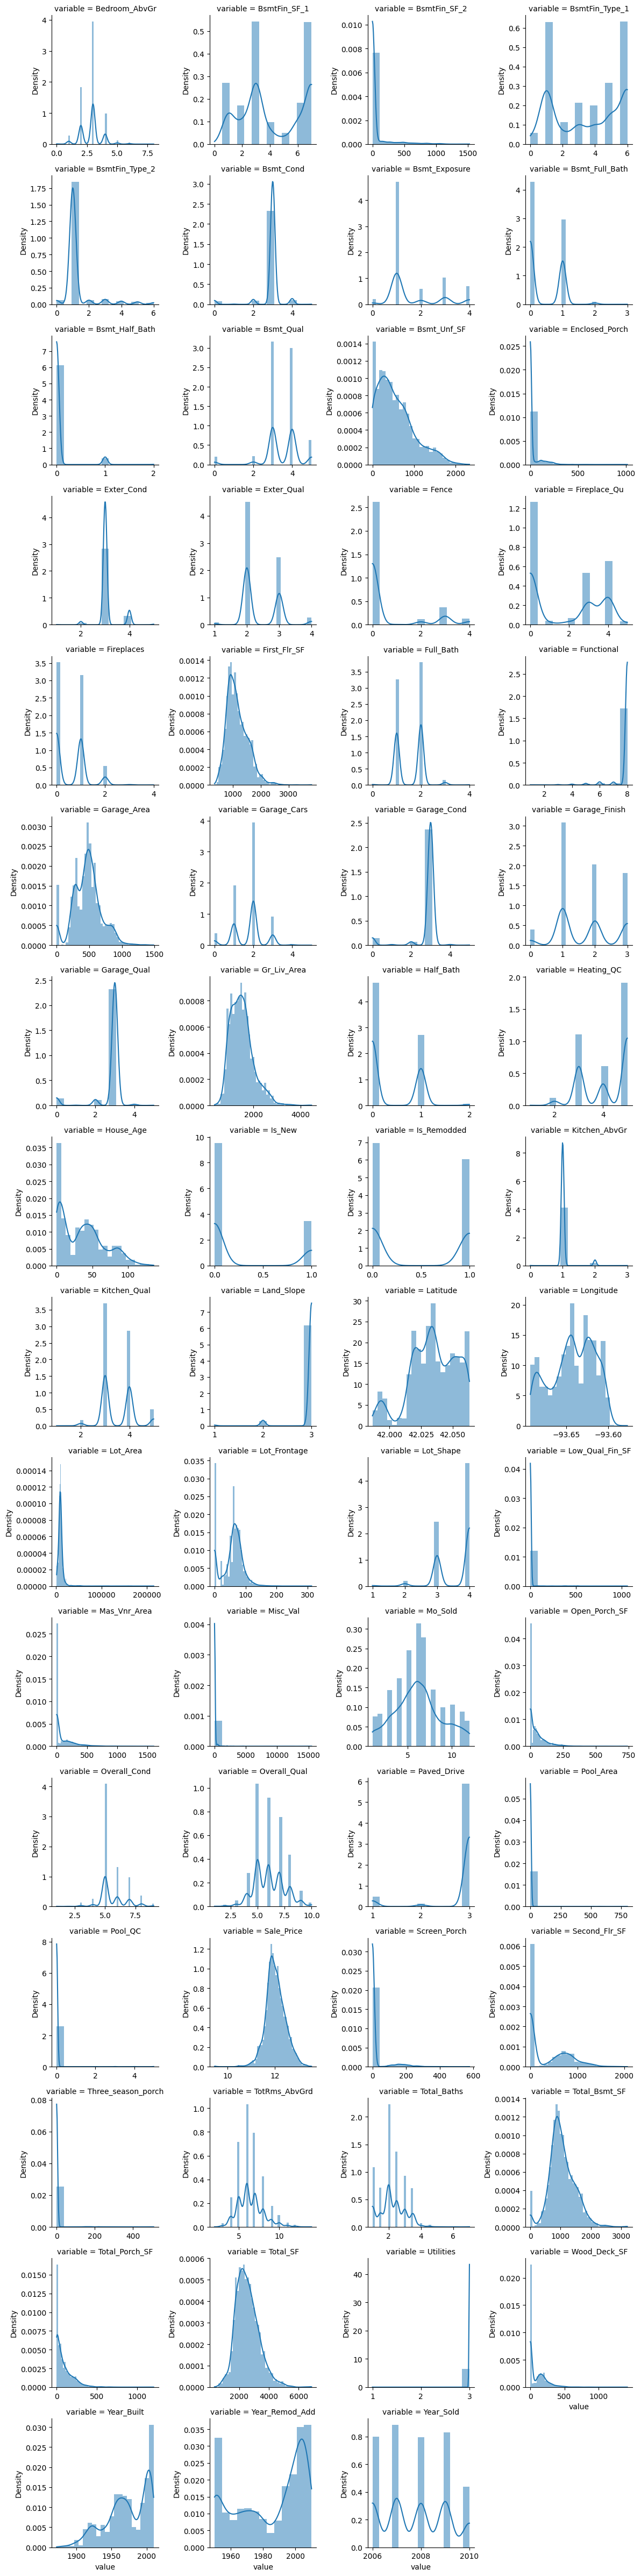

In [25]:
# Plottiamo la distribuzione delle features numeriche con un istogramma e la densità associata
f = pd.melt(df, value_vars = sorted(num_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.histplot, 'value', kde = True, stat = "density", linewidth = 0)

Proviamo a logaritmizzare tutte le features numeriche (non ordinali) che ha senso trasformare:

In [26]:
to_normalize = ['BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'First_Flr_SF', 'Garage_Area', 'Gr_Liv_Area',
                'House_Age', 'Lot_Area', 'Lot_Frontage', 'Low_Qual_Fin_SF', 'Mas_Vnr_Area', 'Misc_Val', 'Open_Porch_SF',
                'Screen_Porch', 'Second_Flr_SF', 'Total_Bsmt_SF', 'Total_Porch_SF', 'Total_SF', 'Wood_Deck_SF']

In [27]:
# Applichiamo il logaritmo per tutte le features da normalizzare
# Siccome log(0) non esiste e molte variabili hanno valori a zero, sommiamo 1 all'argomento
for f in to_normalize:
    df.loc[:, f] = np.log(1 + df.loc[:, f])

Alcune features sembrano averne benificiato...

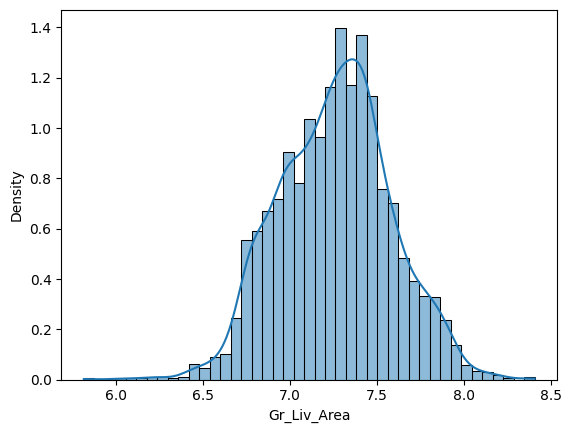

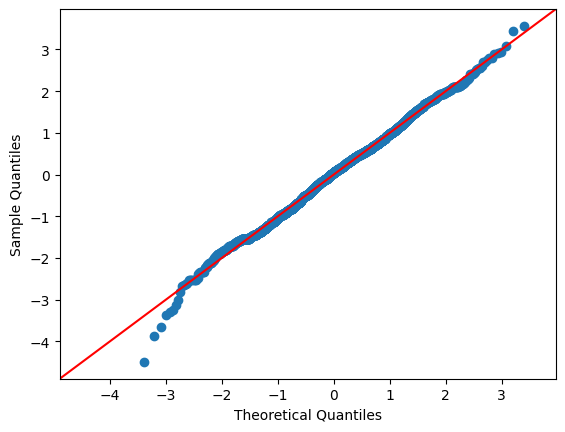

In [28]:
# Plottiamo la distribuzione della feature Gr_Liv_Area con un istogramma e la densità associata
sns.histplot(data = df, x = 'Gr_Liv_Area', kde = True, stat = 'density')
#Vediamo i residui
qqplot(data = df['Gr_Liv_Area'], dist = norm, fit = True, line = "45")
plt.show()

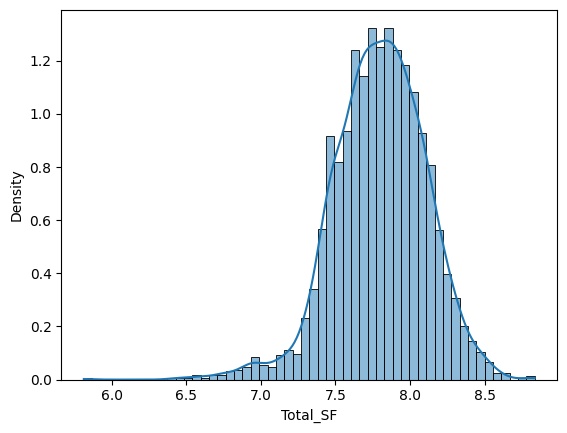

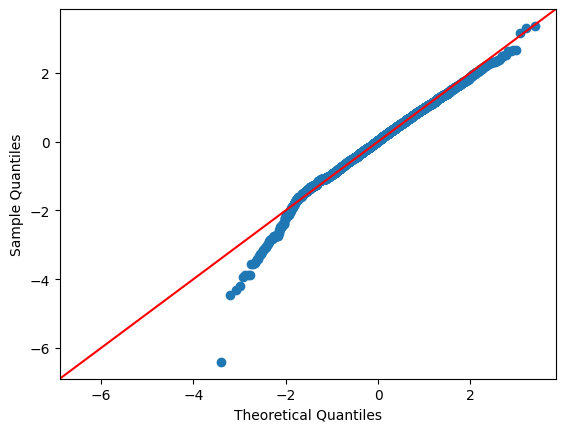

In [29]:
# Plottiamo la distribuzione della feature Total_SF con un istogramma e la densità associata
sns.histplot(data = df, x = 'Total_SF', kde = True, stat = 'density')
#Vediamo i residui
qqplot(data = df['Total_SF'], dist = norm, fit = True, line = "45")
plt.show()

... altre invece non tanto:

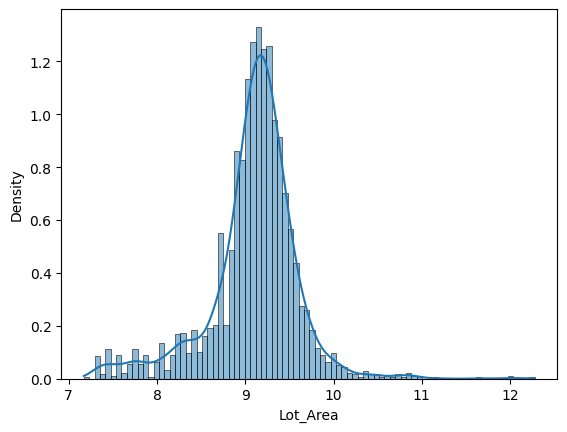

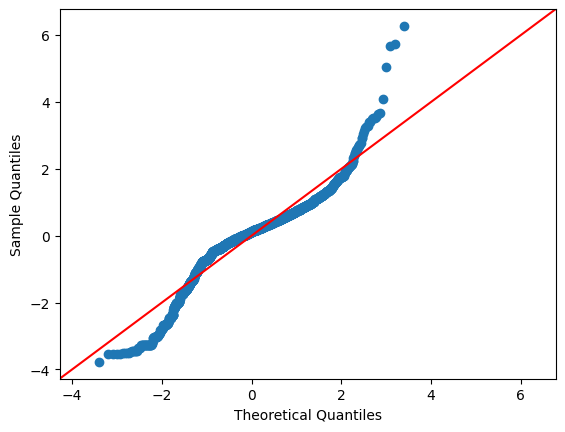

In [30]:
# Plottiamo la distribuzione della feature Lot_Area con un istogramma e la densità associata
sns.histplot(data = df, x = 'Lot_Area', kde = True, stat = 'density')
#Vediamo i residui
qqplot(data = df['Lot_Area'], dist = norm, fit = True, line = "45")
plt.show()

## Rescaling

È sempre consigliato di standardizzazione il set di dati.  
Siccome abbiamo normalizzato le features precedenti, possiamo usare lo StandardScaler a questo scopo:

In [31]:
to_normalize.append('Sale_Price')

scaler = StandardScaler()
df[to_normalize] = scaler.fit_transform(df[to_normalize])

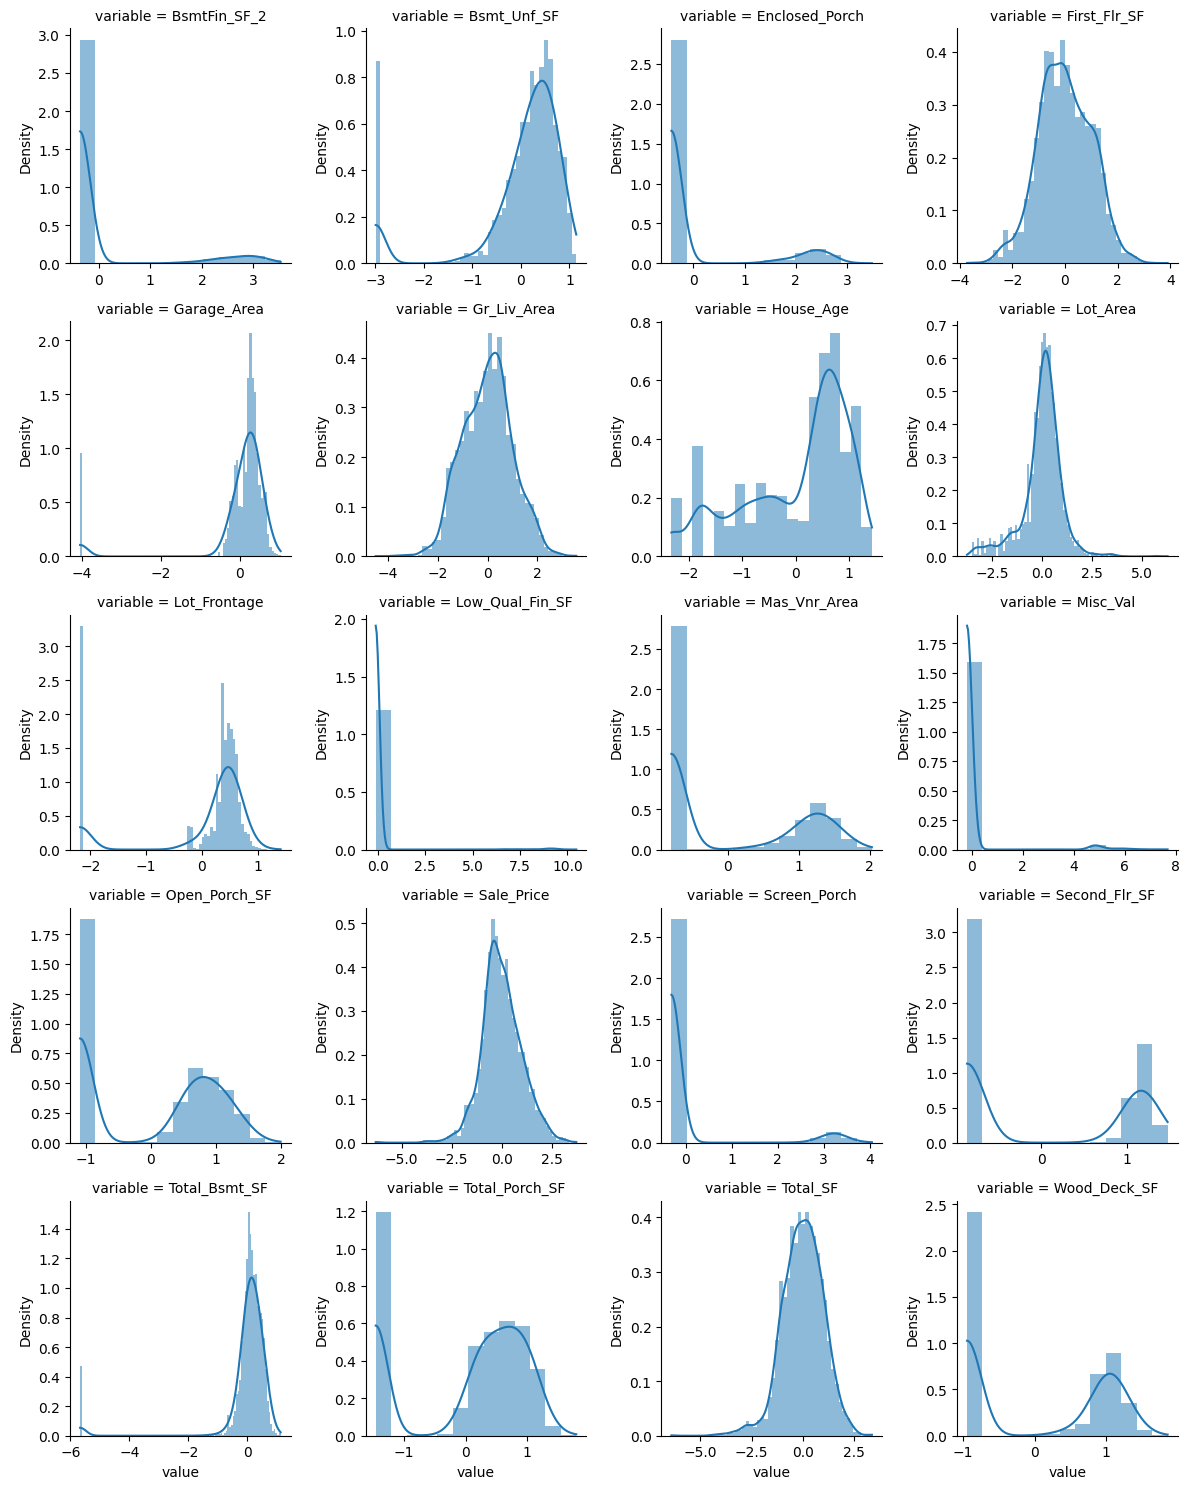

In [32]:
# Plottiamo la distribuzione delle features numeriche trasformate con un istogramma e la densità associata
f = pd.melt(df, value_vars = sorted(to_normalize))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.histplot, 'value', kde = True, stat = "density", linewidth = 0)

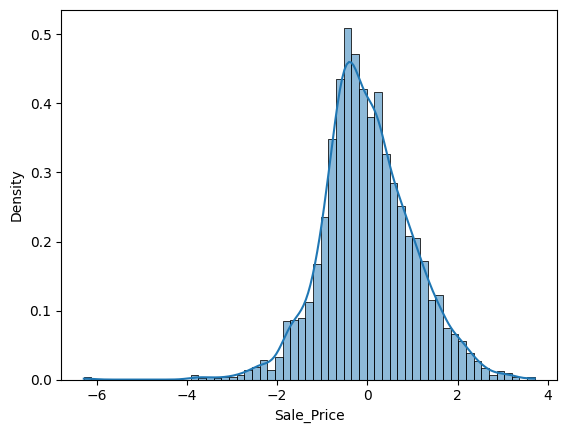

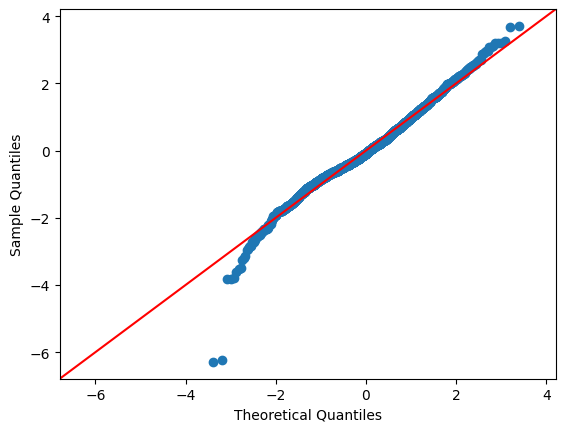

In [33]:
# Plottiamo la distribuzione della feature target Sale_Price con un istogramma e la densità associata
sns.histplot(data = df, x = 'Sale_Price', kde = True, stat = 'density')
#Vediamo i residui
qqplot(data = df['Sale_Price'], dist = norm, fit = True, line = "45")
plt.show()

## Analisi delle Features Categoriche

Visualizziamo nuovamente i grafici per le variabili categoriche, siccome abbiamo convertito un bel po' di variabili a numeriche ordinali.  

Cambiamo tipologia di grafico e usiamo un BoxPlot per vedere più semplicemente molte informazioni utili, tra cui la mediana, i quartili, il massimo e il minimo.

**NOTA**: Le versioni precedenti del documento avevano grafici più "spaziosi"; per qualche ragione sono cambiati. Li teniamo comunque perché qualcosa si riesce comunque a vedere.

/home/stefano/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


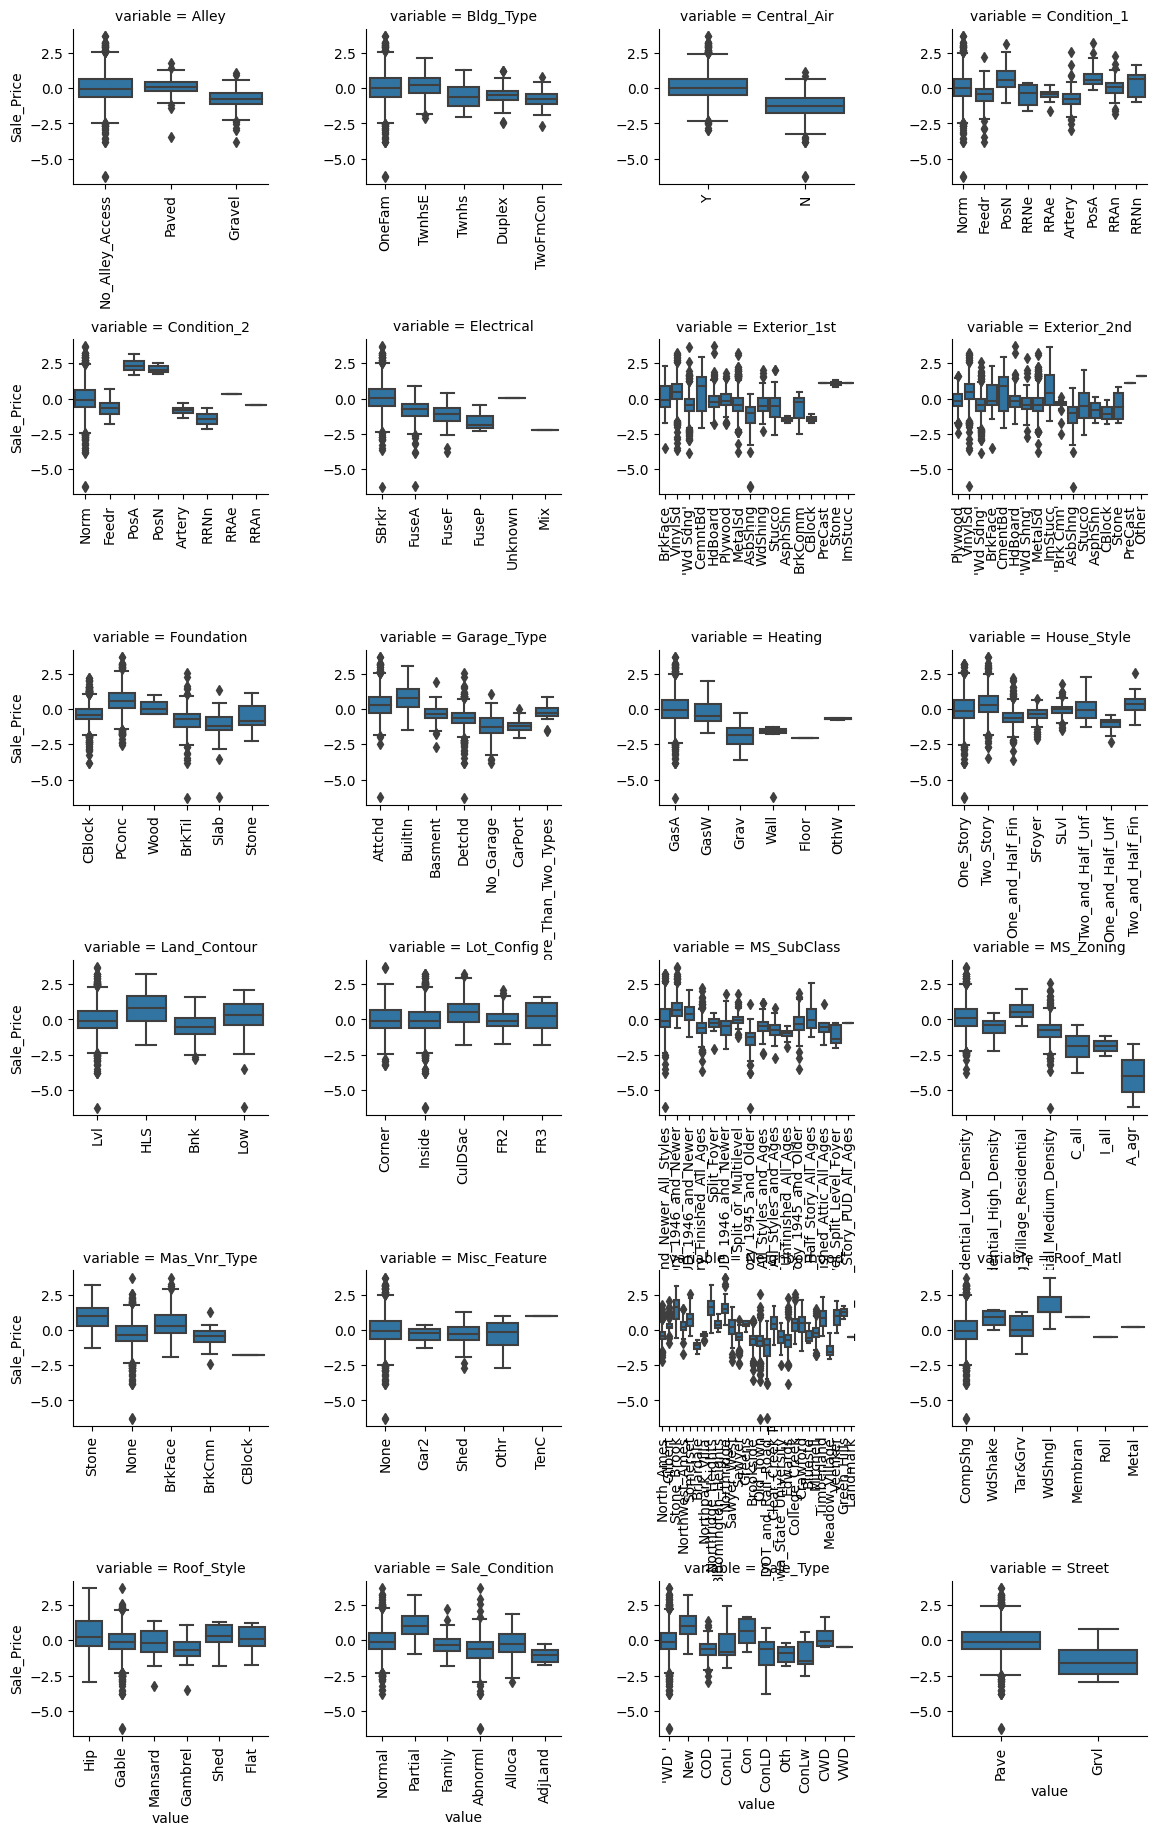

In [34]:
# Plottiamo la distribuzione delle features categoriche con un boxplot rispetto alla feature target Sale_Price
f = pd.melt(df, id_vars = ['Sale_Price'], value_vars = sorted(cat_features))
g = sns.FacetGrid(f, col = 'variable', col_wrap = 4, sharex = False, sharey = False)
g = g.map(sns.boxplot, 'value', 'Sale_Price')

[plt.setp(ax.get_xticklabels(), rotation = 90) for ax in g.axes.flat]

plt.subplots_adjust(hspace = 1.0, wspace = 0.5)
plt.show()

Tra tutte quelle categoriche rimaste, quella che ci interessa maggiormente è Neighborhood: generalmente, una casa molto bella che però viene costruita in un quartiere trasandato vedrà sicuramente il suo prezzo diminuirsi, e forse non di poco!

Un'informazione importante può essere sicuramente la mediana dei prezzi per neighborhood.  
Bisogna fare attenzione però a non barare sul calcolo di questa feature: se viene fatta la mediana usando tutte le case del dataset andremo a calcolare un valore che guarda verso il futuro poiché terrebbe in considerazione anche le case che verranno utilizzate per delle predizioni (test set).

Per ovviare a questo, procediamo secondo questo metodo: data una casa $C_{i}$, calcoliamo la mediana del neighborhood guardando solo le case precedenti, secondo la data di vendita, a $C_{i}$ $(C_{0}, \ldots, C_{i-1})$.  
Possiamo vederlo come un valore che viene aggiornato e aggiunto solo per una nuova casa venduta.

**NOTA:** questo valore non tiene conto del prezzo della casa $C_{i}$ proprio perché dobbiamo predire il prezzo di tale casa!

In [35]:
# Calcoliamo il procedimento descritto sopra usando la funzione add_median_price presa da functions
df = features.add_median_price(df)
df['Neighborhood_Median_Sale_Price']

2425    0.000000
2427    0.015387
2421    0.314811
2422    0.614236
2423    0.622879
          ...   
1178    1.050014
577     1.003454
563     0.956894
574     1.003454
576     1.050014
Name: Neighborhood_Median_Sale_Price, Length: 2927, dtype: float64

In [36]:
# Aggiorniamo le variabili numeriche e categoriche
num_features, cat_features = features.get_feature_groups(df)

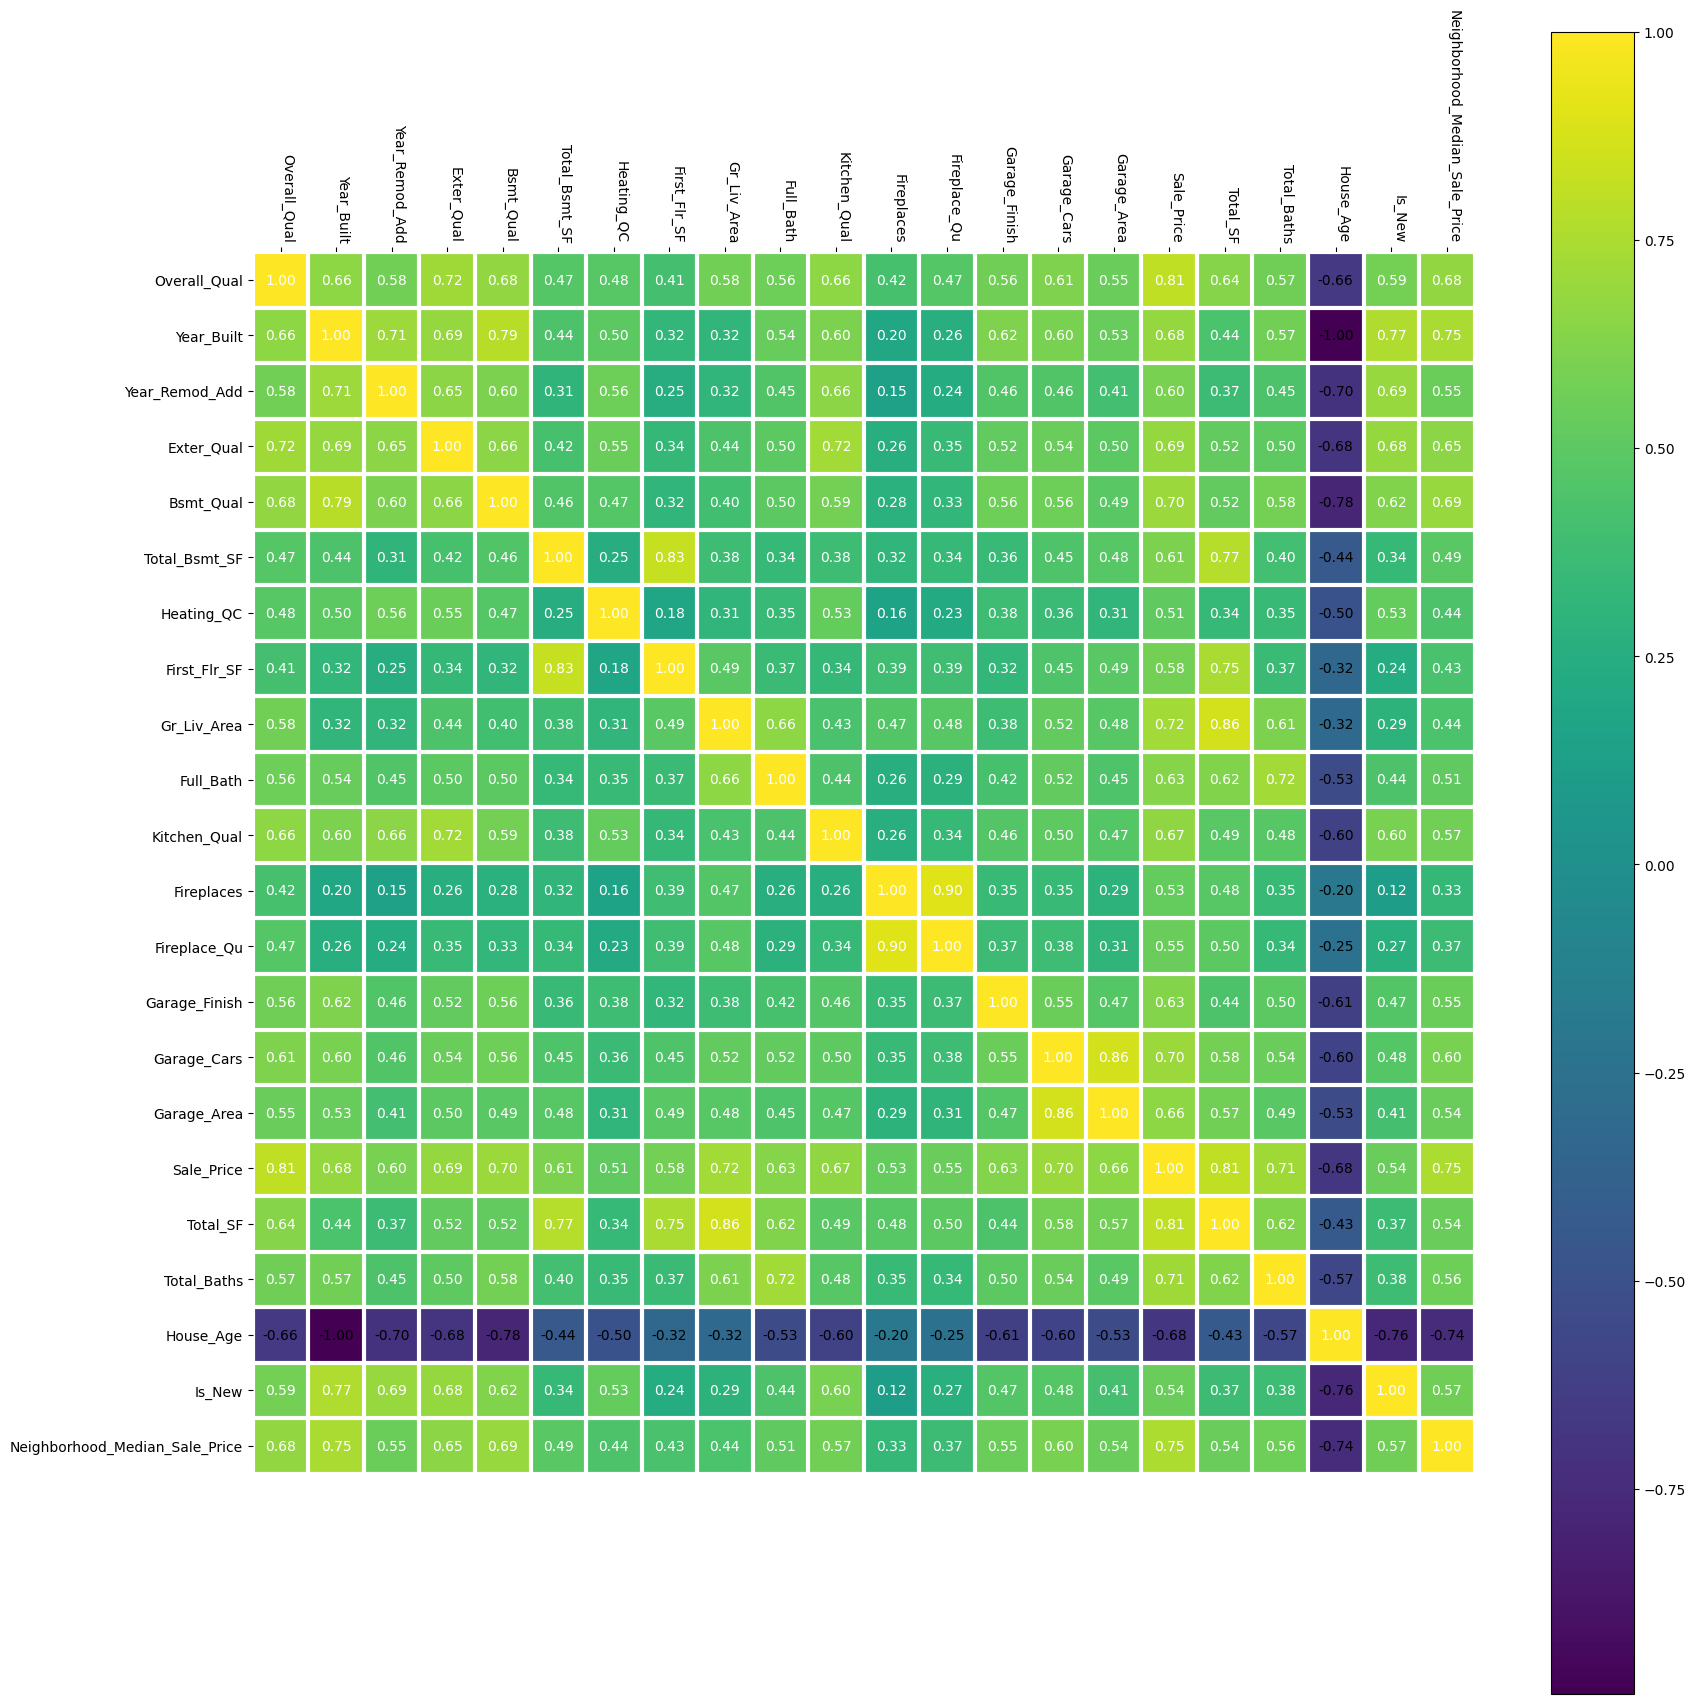

In [37]:
# Calcoliamo la matrice di correlazione tra tutte le features numeriche (comprese quelle aggiunte)
corr_matrix = df[num_features].corr(method = 'spearman')

# Prendiamo una lista delle features che hanno un'alta correlazione
# con 'Sale_Price' per poi plottarle
highest_corrs = corr_matrix.index[ abs(corr_matrix['Sale_Price']) > 0.5 ]

## PLOTTING DELLE FEATURES
fig, ax = plt.subplots(figsize = (18, 18))

# Cambiamo scala dei colori per in quanto la colorazione calda non faceva tanta distinzione tra i valori
im, cbar = htmap.heatmap(df[highest_corrs].corr(method = 'spearman'), highest_corrs,
                         highest_corrs, ax = ax)

# Inseriamo anche i valori all'interno delle celle per maggiore chiarezza
texts = htmap.annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

Come speravamo, l'aggiunta della mediana per Neighborhood risulta essere ben correlata con 'Sale_Price'!

## One-Hot Encoding

Rimangono le altre features categoriche da gestire.

Siccome quelle rimaste sono tutte variabili nominali, una tattica comune è quella di creare delle variabili "dummies" usando il procedimento di OneHotEncoding:

In [38]:
# OneHotEncoding del dataset copia e facciamoci un'altra sorta di "copia" del Train Set e del Test Set
df = pd.get_dummies(data = df, columns = cat_features)
df

Lot_Frontage  Lot_Area  Lot_Shape  Utilities  Land_Slope  Overall_Qual  \
2425      0.183136 -2.125439          4          3           3             7   
2427      0.183136 -2.123480          4          3           3             7   
2421     -2.185220 -2.007543          4          3           3             8   
2422     -2.185220 -2.173043          4          3           3             7   
2423     -2.185220 -2.085350          4          3           3             7   
...            ...       ...        ...        ...         ...           ...   
1178      0.107640  1.028198          2          3           3             8   
577       0.565070  0.155339          4          3           2             8   
563      -2.185220  1.119751          3          3           3             8   
574      -2.185220  0.992519          3          3           3             8   
576       0.762265  1.086985          4          3           3             7   

      Overall_Cond  Year_Built  Year_Remod_Add  Mas_Vnr_Area  ...  \
2425             5        2005            2006      0.292336  ...   
2427             5        2005            2005      1.114337  ...   
2421             5        2003            2003      0.628858  ...   
2422             5        2002            2002      0.628858  ...   
2423             5        2004            2004      0.334853  ...   
...            ...         ...             ...           ...  ...   
1178             5        1996            1996     -0.790677  ...   
577              5        1976            1976      1.236544  ...   
563              8        1980            1980      1.026412  ...   
574              9        1977            2008      1.545469  ...   
576              5        1981            1981     -0.790677  ...   

      Sale_Type_ConLw  Sale_Type_New  Sale_Type_Oth  Sale_Type_VWD  \
2425                0              1              0              0   
2427                0              0              0              0   
2421                0              0              0              0   
2422                0              0              0              0   
2423                0              0              0              0   
...               ...            ...            ...            ...   
1178                0              0              0              0   
577                 0              0              0              0   
563                 0              0              0              0   
574                 0              0              0              0   
576                 0              0              0              0   

      Sale_Condition_Abnorml  Sale_Condition_AdjLand  Sale_Condition_Alloca  \
2425                       0                       0                      0   
2427                       0                       0                      0   
2421                       0                       0                      0   
2422                       0                       0                      0   
2423                       0                       0                      0   
...                      ...                     ...                    ...   
1178                       0                       0                      0   
577                        1                       0                      0   
563                        0                       0                      0   
574                        0                       0                      0   
576                        0                       0                      0   

      Sale_Condition_Family  Sale_Condition_Normal  Sale_Condition_Partial  
2425                      0                      0                       1  
2427                      0                      1                       0  
2421                      0                      1                       0  
2422                      0                      1                       0  
2423                      0              

Dopo la trasformazione, vediamo cosa otteniamo con un'ulteriore studio della correlazione:

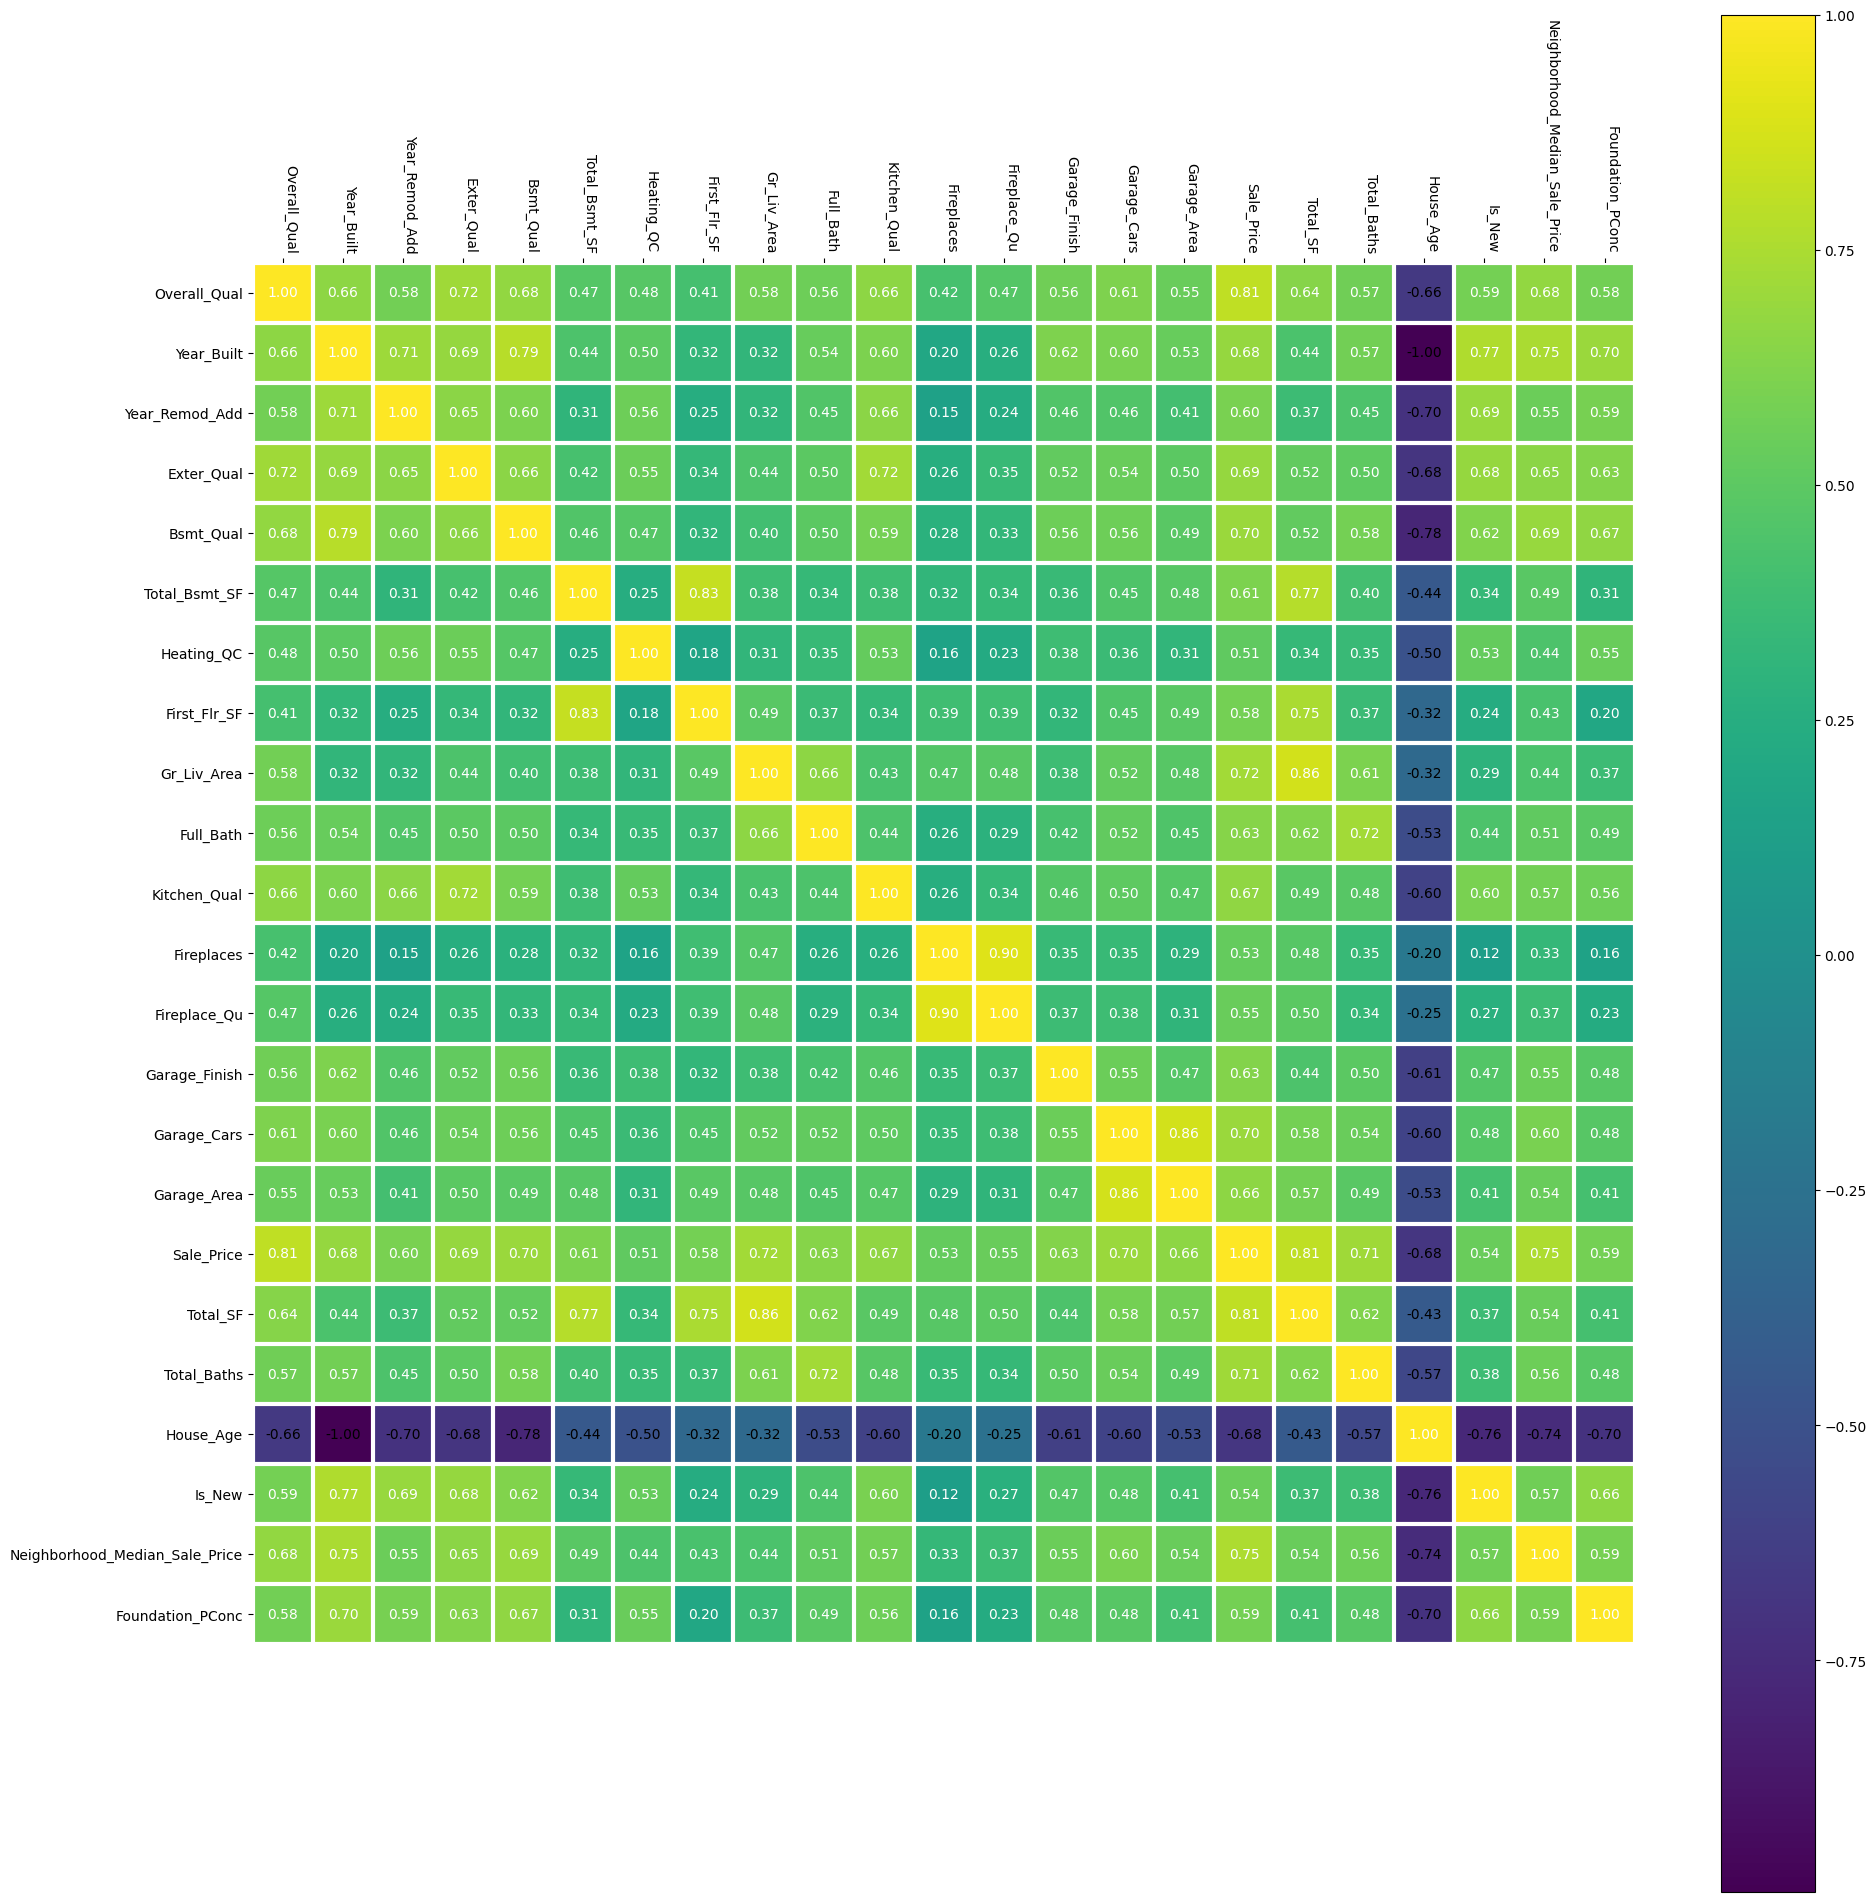

In [39]:
# Calcoliamo la matrice di correlazione di spearman
cat_corr_matrix = df.corr(method = 'spearman')

# Prendiamo una lista delle features che hanno un'alta correlazione
# con 'Sale_Price' per poi plottarle
highest_cat_corrs = cat_corr_matrix.index[ abs(cat_corr_matrix['Sale_Price']) > 0.5 ]

## PLOTTING DELLE FEATURES
fig, ax = plt.subplots(figsize = (20, 20))

# Cambiamo scala dei colori per in quanto la colorazione calda non faceva tanta distinzione tra i valori
im, cbar = htmap.heatmap(df[highest_cat_corrs].corr(method = 'spearman'), highest_cat_corrs,
                         highest_cat_corrs, ax = ax)

# Inseriamo anche i valori all'interno delle celle per maggiore chiarezza
texts = htmap.annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

Possiamo vedere come si siano aggiunte altre due variabili: ['Is_New', 'Foundation_PConc'].  

# Features a bassisima varianza

In [40]:
# Scegliamo il threshold 0.01 dopo aver valutato a occhio il valore che può sembrare buono
selector = VarianceThreshold(threshold=0.01)
selector.fit(df.drop('Sale_Price', axis=1))

# Prendiamo il nome delle features da tenere
kept_features = df.drop('Sale_Price', axis=1).columns[selector.get_support()]

# Riduciamo le features del dataset
df = df.loc[:, list(kept_features) + ['Sale_Price']]

# Feature Selection - Ridge Regressor

In [41]:
X = df.drop('Sale_Price', axis = 1)
y = df['Sale_Price']

X_train, X_test, y_train, y_test = evaluation.split(X, y, 1/3)
X_train

Lot_Frontage  Lot_Area  Lot_Shape  Land_Slope  Overall_Qual  \
2758      0.549422  0.535133          4           3             7   
2780      0.805820  0.855336          3           3             7   
2318      0.275534  0.770884          3           3             8   
2338      0.703178  2.679741          4           3             5   
2436     -2.185220 -0.173701          3           3             6   
...            ...       ...        ...         ...           ...   
505      -2.185220  2.393633          2           3             7   
433       0.745117  0.881992          4           3             9   
439       0.533374  0.153494          4           3             8   
371       0.250497  1.284189          3           3             6   
536       0.677888  0.355407          3           3             7   

      Overall_Cond  Year_Built  Year_Remod_Add  Mas_Vnr_Area  Exter_Qual  ...  \
2758             5        2005            2005     -0.790677           3  ...   
2780             5        2001            2002      1.127209           3  ...   
2318             5        2005            2005      1.265821           3  ...   
2338             5        1955            1955     -0.790677           2  ...   
2436             5        2000            2000     -0.790677           2  ...   
...            ...         ...             ...           ...         ...  ...   
505              6        1994            1994     -0.790677           3  ...   
433              5        2008            2009      1.522771           4  ...   
439              5        2004            2005      1.339313           3  ...   
371              5        1979            1998     -0.790677           2  ...   
536              5        2004            2004     -0.790677           3  ...   

      Garage_Type_No_Garage  Misc_Feature_None  Misc_Feature_Shed  \
2758                      0                  1                  0   
2780                      0                  1                  0   
2318                      0                  1                  0   
2338                      0                  1                  0   
2436                      0                  1                  0   
...                     ...                ...                ...   
505                       0                  1                  0   
433                       0                  1                  0   
439                       0                  1                  0   
371                       0                  1                  0   
536                       0                  1                  0   

      Sale_Type_'WD '  Sale_Type_COD  Sale_Type_New  Sale_Condition_Abnorml  \
2758                1              0              0                       0   
2780                1              0              0                       0   
2318                1              0              0                       0   
2338                1              0              0                       0   
2436                1              0              0                       0   
...               ...            ...            ...                     ...   
505                 1              0              0                       0   
433                 0              0              1                       0   
439                 1              0              0                       0   
371                 1              0              0                       0   
536                 1              0              0                       0   

      Sale_Condition_Family  Sale_Condition_Normal  Sale_Condition_Partial  
2758                      0                      1                       0  
2780                      0                      1                       0  
2318                      0                      1                       0  
2338                      0                      1                       0  
2436                      0              

Per avere un secondo parere, ricaviamo le features più importanti secondo un algoritmo di apprendimento automatico.

> Questa parte di analisi è stata aggiunta dopo aver testato il dataset completo su vari modelli e abbiamo scelto quello più performante per la parte di selezione.

Troviamo il modello migliore secondo il GridSearchCV:

In [42]:
# Crea il modello di regressione basato su Ridge
model = Ridge()

# Definisco la griglia di iperparametri da provare
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.],
    'max_iter': [10000, 20000, 30000, 40000, 50000]
}

In [43]:
# Crea l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model = model, df = df, ylabel = 'Sale_Price')

In [44]:
# Trova quali sono i parametri migliori per il modello
best_params, best_score = ev.grid_search_cv(params=param_grid)
best_params, best_score

({'alpha': 25.0, 'max_iter': 10000}, 0.9299240664724031)

In [45]:
# Inseriamoli in delle variabili per poterle usare con più semplicità
alpha = best_params['alpha']
max_iter = best_params['max_iter']

In [46]:
# Costruisci il regressore con i migliori parametri trovati
ridge = Ridge(alpha=alpha, max_iter=max_iter)
ridge

Ridge(alpha=25.0, max_iter=10000)

In [47]:
# Costruiamo il nostro selettore di features usando la Recursive Features Elimination with Cross-Validation
selector = RFECV(ridge, step = 1, cv = 5, scoring = "neg_mean_squared_error", min_features_to_select = 20, n_jobs=4)
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=Ridge(alpha=25.0, max_iter=10000),
      min_features_to_select=20, n_jobs=4, scoring='neg_mean_squared_error')

In [48]:
# Utilizziamo il supporto, ovvero una mask che ci dice quali features sono state ritenute importanti (True) oppure no (False)
optimal_features = list(X_train.iloc[:, selector.get_support()].columns)
print(f"Numero delle features importanti: {len(optimal_features)}")

Numero delle features importanti: 106


Procediamo con la selezione delle migliori 100 features scelte dal modello:

In [49]:
n = 100  # Top N features da prendere definito da noi

# Rendiamo iterabile (coppia di <id, rank>) il ranking e ordiniamo per le più importanti
iterable_feature_ranks = enumerate(selector.ranking_)
iterable_feature_ranks = sorted(iterable_feature_ranks, key=lambda x: x[1])

# Prendiamo gli ID delle prime N features, le individualizziamo nel train set e le prendiamo
top_n_features = [id for id, rnk in iterable_feature_ranks[:n]]
top_n_features = X_train.iloc[:1, top_n_features].columns.to_list()

Controlliamo che Year_Sold e Mo_Sold ci siano siccome dobbiamo utilizzare per splittare il dataset in train e test durante la valutazione dei modelli, e aggiungiamo Sale_Price per avere le features complete:

In [50]:
if 'Year_Sold' not in top_n_features:
    top_n_features.append('Year_Sold')

if 'Mo_Sold' not in top_n_features:
    top_n_features.append('Mo_Sold')

if 'Sale_Price' not in top_n_features:
    top_n_features.append('Sale_Price')

# Testiamo su un "Dummy" Model

In [51]:
X = df.drop('Sale_Price', axis = 1)
y = df['Sale_Price']

X_train, X_test, y_train, y_test = evaluation.split(X, y, 1/3)
X_train

Lot_Frontage  Lot_Area  Lot_Shape  Land_Slope  Overall_Qual  \
2758      0.549422  0.535133          4           3             7   
2780      0.805820  0.855336          3           3             7   
2318      0.275534  0.770884          3           3             8   
2338      0.703178  2.679741          4           3             5   
2436     -2.185220 -0.173701          3           3             6   
...            ...       ...        ...         ...           ...   
505      -2.185220  2.393633          2           3             7   
433       0.745117  0.881992          4           3             9   
439       0.533374  0.153494          4           3             8   
371       0.250497  1.284189          3           3             6   
536       0.677888  0.355407          3           3             7   

      Overall_Cond  Year_Built  Year_Remod_Add  Mas_Vnr_Area  Exter_Qual  ...  \
2758             5        2005            2005     -0.790677           3  ...   
2780             5        2001            2002      1.127209           3  ...   
2318             5        2005            2005      1.265821           3  ...   
2338             5        1955            1955     -0.790677           2  ...   
2436             5        2000            2000     -0.790677           2  ...   
...            ...         ...             ...           ...         ...  ...   
505              6        1994            1994     -0.790677           3  ...   
433              5        2008            2009      1.522771           4  ...   
439              5        2004            2005      1.339313           3  ...   
371              5        1979            1998     -0.790677           2  ...   
536              5        2004            2004     -0.790677           3  ...   

      Garage_Type_No_Garage  Misc_Feature_None  Misc_Feature_Shed  \
2758                      0                  1                  0   
2780                      0                  1                  0   
2318                      0                  1                  0   
2338                      0                  1                  0   
2436                      0                  1                  0   
...                     ...                ...                ...   
505                       0                  1                  0   
433                       0                  1                  0   
439                       0                  1                  0   
371                       0                  1                  0   
536                       0                  1                  0   

      Sale_Type_'WD '  Sale_Type_COD  Sale_Type_New  Sale_Condition_Abnorml  \
2758                1              0              0                       0   
2780                1              0              0                       0   
2318                1              0              0                       0   
2338                1              0              0                       0   
2436                1              0              0                       0   
...               ...            ...            ...                     ...   
505                 1              0              0                       0   
433                 0              0              1                       0   
439                 1              0              0                       0   
371                 1              0              0                       0   
536                 1              0              0                       0   

      Sale_Condition_Family  Sale_Condition_Normal  Sale_Condition_Partial  
2758                      0                      1                       0  
2780                      0                      1                       0  
2318                      0                      1                       0  
2338                      0                      1                       0  
2436                      0              

In [52]:
# Creiamo un dummy model customizzato
class DummyModel:
  def __init__(self):
    pass

  def fit(self, X, y):
    pass

  def predict(self, X):
    return X['Neighborhood_Median_Sale_Price'].to_numpy()

dummy_model = DummyModel()
dummy_model

In [53]:
# Creiamo l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model=dummy_model, df=df.loc[:, top_n_features], ylabel='Sale_Price')
# Fa splittare il dataset passato al valutatore (test_size = 0.33 di default)
ev.split_dataset()

In [54]:
# Valutiamo il modello secondo un Cross-Validation temporale
ev.temporal_cv(verbose=True).inline()

[Split 0/10] - train_size: 0.093
r2: 0.52141  -  explained_variance: 0.52475  -  rmse: 0.63045  -  mae: 0.33406  -  max_error: 3.37651

[Split 1/10] - train_size: 0.183
r2: 0.65388  -  explained_variance: 0.65766  -  rmse: 0.59969  -  mae: 0.29040  -  max_error: 2.76387

[Split 2/10] - train_size: 0.274
r2: 0.56538  -  explained_variance: 0.56549  -  rmse: 0.71118  -  mae: 0.35609  -  max_error: 2.88497

[Split 3/10] - train_size: 0.365
r2: 0.58594  -  explained_variance: 0.58749  -  rmse: 0.59512  -  mae: 0.33612  -  max_error: 1.82976

[Split 4/10] - train_size: 0.456
r2: 0.59367  -  explained_variance: 0.59607  -  rmse: 0.56767  -  mae: 0.33350  -  max_error: 2.15055

[Split 5/10] - train_size: 0.546
r2: 0.53488  -  explained_variance: 0.53802  -  rmse: 0.68754  -  mae: 0.39861  -  max_error: 1.98722

[Split 6/10] - train_size: 0.637
r2: 0.55886  -  explained_variance: 0.56167  -  rmse: 0.74284  -  mae: 0.38644  -  max_error: 5.21663

[Split 7/10] - train_size: 0.728
r2: 0.48381  - 

'r2: 0.56212  -  explained_variance: 0.56462  -  rmse: 0.64948  -  mae: 0.35627  -  max_error: 2.68637'

In [55]:
# Valutiamo il modello sul test set
ev.evaluate()

r2:                  0.55156
explained_variance:  0.55411
rmse:                0.67677
mae:                 0.36070
max_error:           5.47405

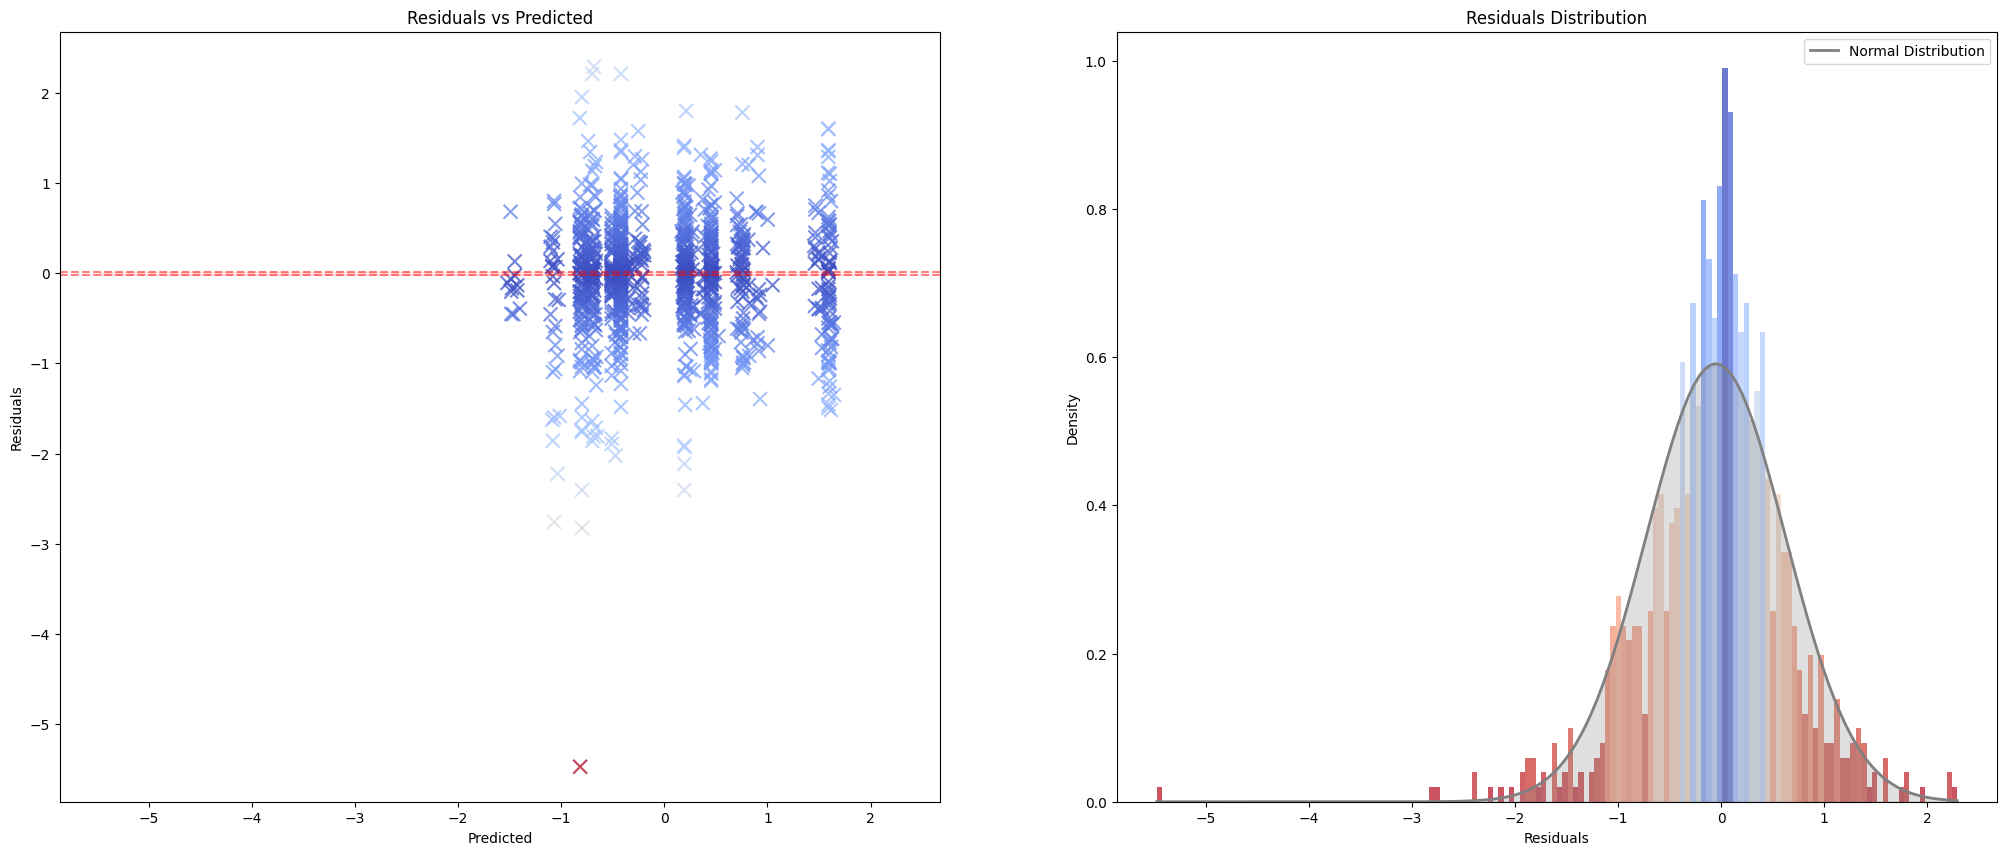

In [56]:
# Mostra i residui e la loro distribuzione
ev.plot_residuals()

# Esportazione del Dataset

Non ci rimane che esportare i dataset per usarli con i modelli

In [57]:
# Esportiamo il dataset con le features rifinite da noi
df.to_csv(r'./data/refined_data.csv', index = False, header = True)

In [58]:
# Esportiamo il dataset con le features scelte dal modello ridge
df[top_n_features].to_csv(r'./data/ridge_features_refined_data.csv', index = False, header = True)